# Dataset energético

O objetivo de cada grupo de trabalho passa por desenvolver o melhor modelo possível capaz de prever a quantidade de energia, em kWh, produzida por painéis solares e injectada, em redes elétricas existentes, a cada hora do dia.

O dataset utilizado nesta competição contém um conjunto de features sendo de destacar a feature Injeção na rede (kWh) . Esta feature indica, numa escala qualitativa (None, Low, Medium, High e Very_High), a quantidade de energia que se injectou na rede elétrica num determinado ponto temporal (i.e., numa determinada hora de um determinado dia). Se o valor desta feature for None, significa que não foi injectada nenhuma energia na rede (ou porque nada foi obtido dos painéis solares, ou porque toda a energia produzida pelos painéis foi consumida localmente). Um valor de Very_High implica a existência de uma quantidade muito alta de energia injectada na rede eléctrica naquele ponto temporal.

Para treino e tuning dos modelos de Machine Learning ser-vos-ão disponibilizados dois datasets com dados energéticos e dois datasets com dados meteorológicos. Tantos os datasets energéticos como os meteorológicos estão divididos por data, i.e., um dos datasets cobre o período de 2021 enquanto que o outro cobre todo o ano de 2022. Os grupos de trabalho poderão adicionar aos datasets qualquer atributo que achem relevante.

Para obtenção de scores na competição, os grupos de trabalho deverão prever, para cada registo do dataset de teste ("energia_202301-202304.csv"), a quantidade de energia que se injectou na rede elétrica num determinado ponto temporal, utilizando a escala None, Low, Medium, High e Very_High.

## The Data

### Treino

- energia_202109-202112.csv
- energia_202201-202212.csv
- meteo_202109-202112.csv
- meteo_202201-202212.csv

### Teste

- energia_202301-202304.csv
- meteo_202301-202304.csv

## Import Libraries

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn as skl

In [108]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit
from sklearn import tree

In [109]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [110]:
from sklearn.metrics import classification_report

## Get the data

In [111]:
energia_2021 = pd.read_csv('daasbstp2023/energia_202109-202112.csv', encoding='latin-1')
energia_2022 = pd.read_csv('daasbstp2023/energia_202201-202212.csv', encoding='latin-1')
meteo_2021 = pd.read_csv('daasbstp2023/meteo_202109-202112.csv', encoding='latin-1')
meteo_2022 = pd.read_csv('daasbstp2023/meteo_202201-202212.csv', encoding='latin-1')

In [112]:
print(energia_2021.columns)
print(meteo_2021.columns)

Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)', 'Injeção na rede (kWh)'],
      dtype='object')
Index(['dt', 'dt_iso', 'city_name', 'temp', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'sea_level', 'grnd_level', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'weather_description'],
      dtype='object')


In [113]:
print('Energia 2021')
print(energia_2021.info())
print('\n')
print('Energia 2022')
print(energia_2022.info())
print('\n\n')
print('Meteo 2021')
print(meteo_2021.info())
print('Meteo 2022')
print(meteo_2022.info())

Energia 2021
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     2256 non-null   object 
 1   Hora                     2256 non-null   int64  
 2   Normal (kWh)             2256 non-null   float64
 3   Horário Económico (kWh)  2256 non-null   float64
 4   Autoconsumo (kWh)        2256 non-null   float64
 5   Injeção na rede (kWh)    566 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 105.9+ KB
None


Energia 2022
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     8760 non-null   object 
 1   Hora                     8760 non-null   int64  
 2   Normal (kWh)             8760 non-null

In [114]:
print('Energia 2021')
energia_2021.head()

Energia 2021


,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2021-09-29,0,0.0,0.0,0.0,NaN
1,2021-09-29,1,0.0,0.0,0.0,NaN
2,2021-09-29,2,0.0,0.0,0.0,NaN
3,2021-09-29,3,0.0,0.0,0.0,NaN
4,2021-09-29,4,0.0,0.0,0.0,NaN


In [115]:
print('Energia 2022')
energia_2022.head()

Energia 2022


,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh)
0,2022-01-01,0,0.0,0.486,0.0,NaN
1,2022-01-01,1,0.0,0.429,0.0,NaN
2,2022-01-01,2,0.0,0.463,0.0,NaN
3,2022-01-01,3,0.0,0.545,0.0,NaN
4,2022-01-01,4,0.0,0.439,0.0,NaN


In [116]:
print('Meteo 2021')
meteo_2021.head()

Meteo 2021


,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description
0,1630454400,2021-09-01 00:00:00 +0000 UTC,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,83,1.18,NaN,78,broken clouds
1,1630458000,2021-09-01 01:00:00 +0000 UTC,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,83,1.46,NaN,92,overcast clouds
2,1630461600,2021-09-01 02:00:00 +0000 UTC,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,88,1.05,NaN,91,overcast clouds
3,1630465200,2021-09-01 03:00:00 +0000 UTC,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,86,0.46,0.14,94,light rain
4,1630468800,2021-09-01 04:00:00 +0000 UTC,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,89,0.93,1.26,95,moderate rain


In [117]:
print('Meteo 2022')
meteo_2022.info()

Meteo 2022
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   8760 non-null   int64  
 1   dt_iso               8760 non-null   object 
 2   city_name            8760 non-null   object 
 3   temp                 8760 non-null   float64
 4   feels_like           8760 non-null   float64
 5   temp_min             8760 non-null   float64
 6   temp_max             8760 non-null   float64
 7   pressure             8760 non-null   int64  
 8   sea_level            0 non-null      float64
 9   grnd_level           0 non-null      float64
 10  humidity             8760 non-null   int64  
 11  wind_speed           8760 non-null   float64
 12  rain_1h              1898 non-null   float64
 13  clouds_all           8760 non-null   int64  
 14  weather_description  8760 non-null   object 
dtypes: float64(8), int64(4), ob

## Join the Data

Criar novas colunas Data e Hora, nos datasets meteo_2021 e meteo_2022, com a informação da coluna dt_iso

Ex:
- dt_iso = 2021-09-01 00:00:00 +0000 UTC
    - Data = 2021-09-01
    - Hour = 00


In [118]:
meteo_2021['Data'] = meteo_2021['dt_iso'].str[:10]
meteo_2021['Hora'] = meteo_2021['dt_iso'].str[11:13].astype(int)
meteo_2022['Data'] = meteo_2022['dt_iso'].str[:10]
meteo_2022['Hora'] = meteo_2022['dt_iso'].str[11:13].astype(int)

In [119]:
print('Meteo 2021')
meteo_2021.info()

Meteo 2021
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   2928 non-null   int64  
 1   dt_iso               2928 non-null   object 
 2   city_name            2928 non-null   object 
 3   temp                 2928 non-null   float64
 4   feels_like           2928 non-null   float64
 5   temp_min             2928 non-null   float64
 6   temp_max             2928 non-null   float64
 7   pressure             2928 non-null   int64  
 8   sea_level            0 non-null      float64
 9   grnd_level           0 non-null      float64
 10  humidity             2928 non-null   int64  
 11  wind_speed           2928 non-null   float64
 12  rain_1h              537 non-null    float64
 13  clouds_all           2928 non-null   int64  
 14  weather_description  2928 non-null   object 
 15  Data                 2928 n

In [120]:
print('Meteo 2022')
meteo_2022.head()

Meteo 2022


,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,rain_1h,clouds_all,weather_description,Data,Hora
0,1640995200,2022-01-01 00:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.15,NaN,97,overcast clouds,2022-01-01,0
1,1640998800,2022-01-01 01:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,65,3.14,NaN,58,broken clouds,2022-01-01,1
2,1641002400,2022-01-01 02:00:00 +0000 UTC,local,16.59,16.03,15.67,16.72,1024,NaN,NaN,66,3.12,NaN,23,few clouds,2022-01-01,2
3,1641006000,2022-01-01 03:00:00 +0000 UTC,local,13.59,12.75,11.61,16.16,1023,NaN,NaN,67,3.08,NaN,22,few clouds,2022-01-01,3
4,1641009600,2022-01-01 04:00:00 +0000 UTC,local,14.97,14.27,14.72,15.66,1023,NaN,NaN,67,3.12,NaN,15,few clouds,2022-01-01,4


In [121]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.5503,
	"longitude": -8.42,
	"start_date": "2021-09-01",
	"end_date": "2021-12-31",
	"hourly": ["wind_speed_10m", "is_day", "sunshine_duration", "direct_radiation", "rain", "shortwave_radiation","diffuse_radiation"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_wind_speed_10m = hourly.Variables(0).ValuesAsNumpy()
hourly_is_day = hourly.Variables(1).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(2).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(5).ValuesAsNumpy()
hourly_diffuse_radiation = hourly.Variables(6).ValuesAsNumpy()


hourly_data = {}
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["is_day"] = hourly_is_day
hourly_data["sunshine_duration"] = hourly_sunshine_duration
hourly_data["direct_radiation"] = hourly_direct_radiation
hourly_data["rain"] = hourly_rain
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
hourly_data["diffuse_radiation"] = hourly_diffuse_radiation

hourly_dataframe_2021 = pd.DataFrame(data = hourly_data)
meteoo_2021 = pd.concat([meteo_2021, hourly_dataframe_2021], axis=1)
meteoo_2021.head()


Coordinates 41.581722259521484°E -8.441558837890625°N
Elevation 193.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,...,weather_description,Data,Hora,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation
0,1630454400,2021-09-01 00:00:00 +0000 UTC,local,18.74,18.84,15.72,20.34,1015,NaN,NaN,...,broken clouds,2021-09-01,0,2.620839,0.0,0.0,0.0,0.0,0.0,0.0
1,1630458000,2021-09-01 01:00:00 +0000 UTC,local,18.73,18.83,15.72,20.34,1014,NaN,NaN,...,overcast clouds,2021-09-01,1,3.259938,0.0,0.0,0.0,0.0,0.0,0.0
2,1630461600,2021-09-01 02:00:00 +0000 UTC,local,17.84,17.98,16.72,20.34,1014,NaN,NaN,...,overcast clouds,2021-09-01,2,4.693826,0.0,0.0,0.0,0.0,0.0,0.0
3,1630465200,2021-09-01 03:00:00 +0000 UTC,local,18.27,18.40,16.68,20.34,1014,NaN,NaN,...,light rain,2021-09-01,3,5.411986,0.0,0.0,0.0,4.0,0.0,0.0
4,1630468800,2021-09-01 04:00:00 +0000 UTC,local,17.81,17.97,16.12,20.34,1013,NaN,NaN,...,moderate rain,2021-09-01,4,4.693826,0.0,0.0,0.0,0.4,0.0,0.0


In [122]:
meteoo_2021['is_day'].value_counts()

is_day
0.0    1610
1.0    1318
Name: count, dtype: int64

In [123]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.5503,
	"longitude": -8.42,
	"start_date": "2022-01-01",
	"end_date": "2022-12-31",
	"hourly": ["wind_speed_10m", "is_day", "sunshine_duration", "direct_radiation", "rain", "shortwave_radiation","diffuse_radiation"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_wind_speed_10m = hourly.Variables(0).ValuesAsNumpy()
hourly_is_day = hourly.Variables(1).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(2).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(5).ValuesAsNumpy()
hourly_diffuse_radiation = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {}
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["is_day"] = hourly_is_day
hourly_data["sunshine_duration"] = hourly_sunshine_duration
hourly_data["direct_radiation"] = hourly_direct_radiation
hourly_data["rain"] = hourly_rain
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
hourly_data["diffuse_radiation"] = hourly_diffuse_radiation


hourly_dataframe_2022 = pd.DataFrame(data = hourly_data)
meteoo_2022 = pd.concat([meteo_2022, hourly_dataframe_2022], axis=1)

meteoo_2022.head()

Coordinates 41.581722259521484°E -8.441558837890625°N
Elevation 193.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,...,weather_description,Data,Hora,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation
0,1640995200,2022-01-01 00:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,...,overcast clouds,2022-01-01,0,13.044722,0.0,0.0,0.0,0.0,0.0,0.0
1,1640998800,2022-01-01 01:00:00 +0000 UTC,local,16.59,16.00,16.21,16.72,1024,NaN,NaN,...,broken clouds,2022-01-01,1,13.044722,0.0,0.0,0.0,0.0,0.0,0.0
2,1641002400,2022-01-01 02:00:00 +0000 UTC,local,16.59,16.03,15.67,16.72,1024,NaN,NaN,...,few clouds,2022-01-01,2,13.551501,0.0,0.0,0.0,0.0,0.0,0.0
3,1641006000,2022-01-01 03:00:00 +0000 UTC,local,13.59,12.75,11.61,16.16,1023,NaN,NaN,...,few clouds,2022-01-01,3,14.336861,0.0,0.0,0.0,0.0,0.0,0.0
4,1641009600,2022-01-01 04:00:00 +0000 UTC,local,14.97,14.27,14.72,15.66,1023,NaN,NaN,...,few clouds,2022-01-01,4,14.291592,0.0,0.0,0.0,0.0,0.0,0.0


Juntar os datasets tendo em conta os fields data e a hora.

In [124]:
# Merge the DataFrames based on "Data" and "Hora" columns
energia_meteo_2021 = pd.merge(energia_2021, meteoo_2021, on=["Data", "Hora"],how='outer')
energia_meteo_2022 = pd.merge(energia_2022, meteoo_2022, on=["Data", "Hora"],how='outer')

# Concatenate the merged DataFrames
energia_meteo = pd.concat([energia_meteo_2021, energia_meteo_2022])

# Save the merged data to a new CSV file
energia_meteo.to_csv("daasbstp2023/merged_data.csv", index=False)

# No enunciado avisa que None é quando não há infos, ao junta-los, os None viram NaN
energia_meteo['Injeção na rede (kWh)'].fillna('None', inplace=True)

In [125]:
energia_meteo.columns

Index(['Data', 'Hora', 'Normal (kWh)', 'Horário Económico (kWh)',
       'Autoconsumo (kWh)', 'Injeção na rede (kWh)', 'dt', 'dt_iso',
       'city_name', 'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure',
       'sea_level', 'grnd_level', 'humidity', 'wind_speed', 'rain_1h',
       'clouds_all', 'weather_description', 'wind_speed_10m', 'is_day',
       'sunshine_duration', 'direct_radiation', 'rain', 'shortwave_radiation',
       'diffuse_radiation'],
      dtype='object')

In [126]:
energia_meteo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 0 to 8759
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11688 non-null  object 
 1   Hora                     11688 non-null  int64  
 2   Normal (kWh)             11016 non-null  float64
 3   Horário Económico (kWh)  11016 non-null  float64
 4   Autoconsumo (kWh)        11016 non-null  float64
 5   Injeção na rede (kWh)    11688 non-null  object 
 6   dt                       11688 non-null  int64  
 7   dt_iso                   11688 non-null  object 
 8   city_name                11688 non-null  object 
 9   temp                     11688 non-null  float64
 10  feels_like               11688 non-null  float64
 11  temp_min                 11688 non-null  float64
 12  temp_max                 11688 non-null  float64
 13  pressure                 11688 non-null  int64  
 14  sea_level                0 n

In [127]:
energia_meteo.tail()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),dt,dt_iso,city_name,temp,...,rain_1h,clouds_all,weather_description,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation
8755,2022-12-31,19,1.693,0.000,0.0,None,1672513200,2022-12-31 19:00:00 +0000 UTC,local,15.70,...,3.58,100,moderate rain,21.707731,0.0,0.0,0.0,2.0,0.0,0.0
8756,2022-12-31,20,1.327,0.000,0.0,None,1672516800,2022-12-31 20:00:00 +0000 UTC,local,15.55,...,4.20,100,heavy intensity rain,23.319553,0.0,0.0,0.0,3.6,0.0,0.0
8757,2022-12-31,21,0.757,0.000,0.0,None,1672520400,2022-12-31 21:00:00 +0000 UTC,local,13.45,...,4.23,100,heavy intensity rain,19.829433,0.0,0.0,0.0,2.8,0.0,0.0
8758,2022-12-31,22,0.000,0.675,0.0,None,1672524000,2022-12-31 22:00:00 +0000 UTC,local,12.93,...,3.90,100,moderate rain,17.673029,0.0,0.0,0.0,4.4,0.0,0.0
8759,2022-12-31,23,0.000,0.403,0.0,None,1672527600,2022-12-31 23:00:00 +0000 UTC,local,12.93,...,4.07,100,heavy intensity rain,17.373497,0.0,0.0,0.0,4.6,0.0,0.0


In [128]:
energia_meteo.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),dt,dt_iso,city_name,temp,...,rain_1h,clouds_all,weather_description,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00 +0000 UTC,local,13.97,...,NaN,87,overcast clouds,10.041354,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00 +0000 UTC,local,13.48,...,NaN,91,overcast clouds,6.849467,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00 +0000 UTC,local,12.93,...,NaN,93,overcast clouds,6.519877,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00 +0000 UTC,local,12.61,...,NaN,95,overcast clouds,6.638072,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00 +0000 UTC,local,12.61,...,NaN,93,overcast clouds,6.379216,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
%pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [130]:
import holidays

def eh_feriado(data):
    pt_holidays = holidays.Portugal()
    return data in pt_holidays

# Convertendo a coluna de data para o tipo datetime e garantindo o formato correto
energia_meteo['Data'] = pd.to_datetime(energia_meteo['Data'], format='%Y-%m-%d')

# Adicionando a coluna de feriado
energia_meteo['feriado'] = energia_meteo['Data'].apply(eh_feriado)

# Adicionando a coluna do dia da semana
energia_meteo['dia_da_semana'] = energia_meteo['Data'].dt.day_name(locale='pt_PT')

energia_meteo.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),dt,dt_iso,city_name,temp,...,weather_description,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana
0,2021-09-29,0,0.0,0.0,0.0,None,1632873600,2021-09-29 00:00:00 +0000 UTC,local,13.97,...,overcast clouds,10.041354,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
1,2021-09-29,1,0.0,0.0,0.0,None,1632877200,2021-09-29 01:00:00 +0000 UTC,local,13.48,...,overcast clouds,6.849467,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
2,2021-09-29,2,0.0,0.0,0.0,None,1632880800,2021-09-29 02:00:00 +0000 UTC,local,12.93,...,overcast clouds,6.519877,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
3,2021-09-29,3,0.0,0.0,0.0,None,1632884400,2021-09-29 03:00:00 +0000 UTC,local,12.61,...,overcast clouds,6.638072,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
4,2021-09-29,4,0.0,0.0,0.0,None,1632888000,2021-09-29 04:00:00 +0000 UTC,local,12.61,...,overcast clouds,6.379216,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta


In [131]:
# give a date when feriado is True
energia_meteo[energia_meteo['feriado']==True]

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),dt,dt_iso,city_name,temp,...,weather_description,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana
144,2021-10-05,0,0.546,0.000,0.0,None,1633392000,2021-10-05 00:00:00 +0000 UTC,local,15.15,...,overcast clouds,12.245294,0.0,0.0,0.0,0.6,0.0,0.0,True,Terça
145,2021-10-05,1,0.492,0.000,0.0,None,1633395600,2021-10-05 01:00:00 +0000 UTC,local,14.64,...,light rain,13.722565,0.0,0.0,0.0,0.4,0.0,0.0,True,Terça
146,2021-10-05,2,0.320,0.000,0.0,None,1633399200,2021-10-05 02:00:00 +0000 UTC,local,15.15,...,light rain,11.792404,0.0,0.0,0.0,2.1,0.0,0.0,True,Terça
147,2021-10-05,3,0.319,0.000,0.0,None,1633402800,2021-10-05 03:00:00 +0000 UTC,local,15.18,...,light rain,12.768586,0.0,0.0,0.0,1.1,0.0,0.0,True,Terça
148,2021-10-05,4,0.317,0.000,0.0,None,1633406400,2021-10-05 04:00:00 +0000 UTC,local,15.18,...,light rain,10.163227,0.0,0.0,0.0,0.5,0.0,0.0,True,Terça
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8611,2022-12-25,19,1.664,0.000,0.0,None,1671994800,2022-12-25 19:00:00 +0000 UTC,local,12.46,...,light rain,12.783802,0.0,0.0,0.0,0.1,0.0,0.0,True,Domingo
8612,2022-12-25,20,0.827,0.000,0.0,None,1671998400,2022-12-25 20:00:00 +0000 UTC,local,12.40,...,light rain,10.464798,0.0,0.0,0.0,0.5,0.0,0.0,True,Domingo
8613,2022-12-25,21,0.591,0.000,0.0,None,1672002000,2022-12-25 21:00:00 +0000 UTC,local,12.40,...,light rain,13.104198,0.0,0.0,0.0,1.5,0.0,0.0,True,Domingo
8614,2022-12-25,22,0.000,0.614,0.0,None,1672005600,2022-12-25 22:00:00 +0000 UTC,local,12.40,...,light rain,7.993298,0.0,0.0,0.0,0.2,0.0,0.0,True,Domingo


Eliminar dt_iso e dt

In [132]:
energia_meteo.drop(['dt_iso'], axis=1, inplace=True)
energia_meteo.drop(['dt'], axis=1, inplace=True)

In [133]:
energia_meteo.nunique()

Data                        487
Hora                         24
Normal (kWh)               1282
Horário Económico (kWh)     851
Autoconsumo (kWh)           752
Injeção na rede (kWh)         5
city_name                     1
temp                       2423
feels_like                 2702
temp_min                    488
temp_max                    550
pressure                     41
sea_level                     0
grnd_level                    0
humidity                     82
wind_speed                  771
rain_1h                     371
clouds_all                  101
weather_description           8
wind_speed_10m             1386
is_day                        2
sunshine_duration           988
direct_radiation            822
rain                         91
shortwave_radiation         936
diffuse_radiation           365
feriado                       2
dia_da_semana                 7
dtype: int64

Como city_name apenas tem um valor único, a coluna será eliminada.

In [134]:
energia_meteo.drop(['city_name'], axis=1, inplace=True)

## Handling missing data and possible data transformations
- Remove missing values, outliers, and unnecessary rows/ columns
- Check and impute null values
- Check Imbalanced data
- Re-indexing and reformatting our data

### 1. Missing Values

Data                           0
Hora                           0
Normal (kWh)                 672
Horário Económico (kWh)      672
Autoconsumo (kWh)            672
Injeção na rede (kWh)          0
temp                           0
feels_like                     0
temp_min                       0
temp_max                       0
pressure                       0
sea_level                  11688
grnd_level                 11688
humidity                       0
wind_speed                     0
rain_1h                     9253
clouds_all                     0
weather_description            0
wind_speed_10m                 0
is_day                         0
sunshine_duration              0
direct_radiation               0
rain                           0
shortwave_radiation            0
diffuse_radiation              0
feriado                        0
dia_da_semana                  0
dtype: int64

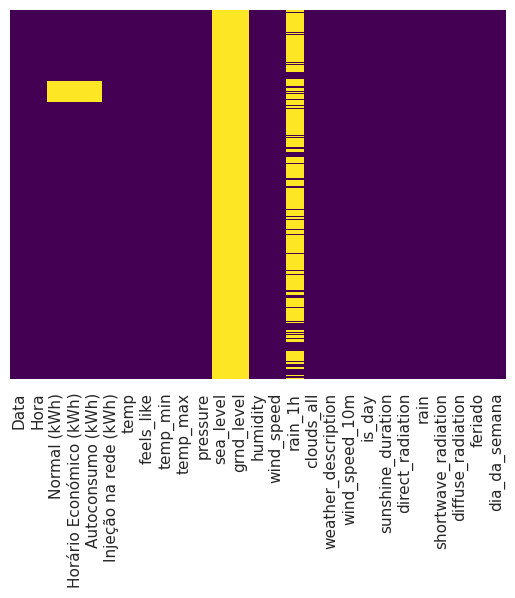

In [135]:
sns.heatmap(energia_meteo.isnull(),yticklabels=False,cbar=False,cmap='viridis')
energia_meteo.isnull().sum()

#### - Drop or fill

Começamos por eliminar as colunas que contém todos os vals a null - sea_level e grnd_level já que não contêm nenhuma informação

In [136]:
energia_meteo.drop(['sea_level','grnd_level'],axis=1,inplace=True)
energia_meteo.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),temp,feels_like,temp_min,temp_max,...,weather_description,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana
0,2021-09-29,0,0.0,0.0,0.0,None,13.97,13.54,11.45,14.04,...,overcast clouds,10.041354,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
1,2021-09-29,1,0.0,0.0,0.0,None,13.48,13.02,13.43,13.90,...,overcast clouds,6.849467,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
2,2021-09-29,2,0.0,0.0,0.0,None,12.93,12.47,12.72,13.43,...,overcast clouds,6.519877,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
3,2021-09-29,3,0.0,0.0,0.0,None,12.61,12.15,10.34,12.93,...,overcast clouds,6.638072,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
4,2021-09-29,4,0.0,0.0,0.0,None,12.61,12.17,9.79,12.93,...,overcast clouds,6.379216,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta


Agora vamos analizar a feature rain_1h

In [137]:
energia_meteo['rain_1h'].describe()

count    2435.000000
mean        0.884760
std         1.073453
min         0.100000
25%         0.210000
50%         0.450000
75%         1.070000
max         7.450000
Name: rain_1h, dtype: float64

In [138]:
energia_meteo.drop(['rain_1h'],axis=1,inplace=True)

Teoria: os NaN provavelmente provêem de horas sem chuva, logo, podemos substituir por 0

Então vamos testar colocar os vals nulls de rain_1h a zero

In [139]:
# energia_meteo.fillna(0,inplace=True)

In [140]:
energia_meteo.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),temp,feels_like,temp_min,temp_max,...,weather_description,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana
0,2021-09-29,0,0.0,0.0,0.0,None,13.97,13.54,11.45,14.04,...,overcast clouds,10.041354,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
1,2021-09-29,1,0.0,0.0,0.0,None,13.48,13.02,13.43,13.90,...,overcast clouds,6.849467,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
2,2021-09-29,2,0.0,0.0,0.0,None,12.93,12.47,12.72,13.43,...,overcast clouds,6.519877,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
3,2021-09-29,3,0.0,0.0,0.0,None,12.61,12.15,10.34,12.93,...,overcast clouds,6.638072,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
4,2021-09-29,4,0.0,0.0,0.0,None,12.61,12.17,9.79,12.93,...,overcast clouds,6.379216,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta


Data                         0
Hora                         0
Normal (kWh)               672
Horário Económico (kWh)    672
Autoconsumo (kWh)          672
Injeção na rede (kWh)        0
temp                         0
feels_like                   0
temp_min                     0
temp_max                     0
pressure                     0
humidity                     0
wind_speed                   0
clouds_all                   0
weather_description          0
wind_speed_10m               0
is_day                       0
sunshine_duration            0
direct_radiation             0
rain                         0
shortwave_radiation          0
diffuse_radiation            0
feriado                      0
dia_da_semana                0
dtype: int64

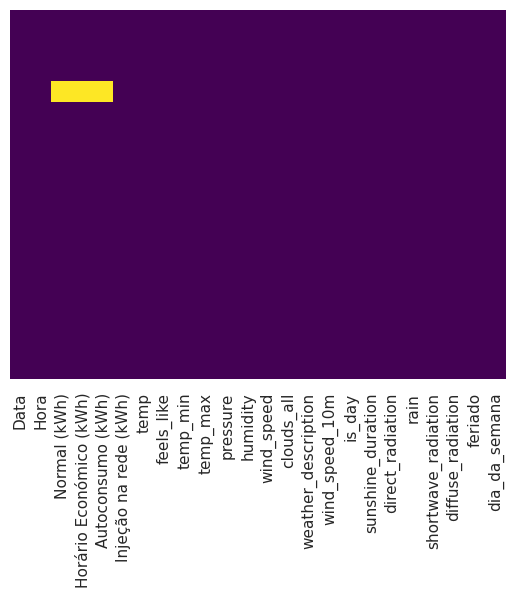

In [141]:
sns.heatmap(energia_meteo.isnull(),yticklabels=False,cbar=False,cmap='viridis')
energia_meteo.isnull().sum()

In [142]:
for column in energia_meteo.columns:
    print(f"Valores da coluna {column}:")
    print(energia_meteo[column].value_counts())

Valores da coluna Data:
Data
2021-09-29    24
2022-07-03    24
2022-07-31    24
2022-07-30    24
2022-07-29    24
              ..
2022-02-06    24
2022-02-05    24
2022-02-04    24
2022-02-03    24
2022-12-31    24
Name: count, Length: 487, dtype: int64
Valores da coluna Hora:
Hora
0     487
1     487
22    487
21    487
20    487
19    487
18    487
17    487
16    487
15    487
14    487
13    487
12    487
11    487
10    487
9     487
8     487
7     487
6     487
5     487
4     487
3     487
2     487
23    487
Name: count, dtype: int64
Valores da coluna Normal (kWh):
Normal (kWh)
0.000    6018
0.001      23
0.008      19
0.252      17
0.016      17
         ... 
1.479       1
1.024       1
0.839       1
0.832       1
1.327       1
Name: count, Length: 1282, dtype: int64
Valores da coluna Horário Económico (kWh):
Horário Económico (kWh)
0.000    6813
0.263      34
0.256      31
0.321      29
0.260      27
         ... 
1.811       1
1.571       1
1.440       1
1.675       1
0.70

## Handling Categorical Features

Injeção na rede (kWh)
None         8449
High         1103
Medium       1098
Very High     606
Low           432
Name: count, dtype: int64


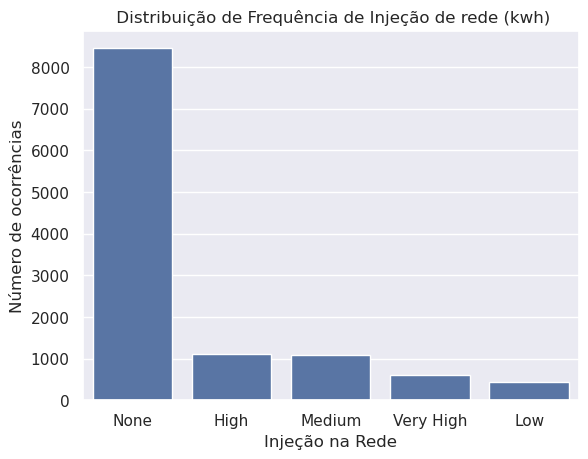

In [143]:
inj_rede_count = energia_meteo['Injeção na rede (kWh)'].value_counts()
print(inj_rede_count)
# remove None count
# inj_rede_count = inj_rede_count.drop('None')
sns.set(style="darkgrid")
sns.barplot(x=inj_rede_count.index, y=inj_rede_count.values)
plt.title(' Distribuição de Frequência de Injeção de rede (kwh)')
plt.ylabel('Número de ocorrências', fontsize=12)
plt.xlabel('Injeção na Rede', fontsize=12)
plt.show()

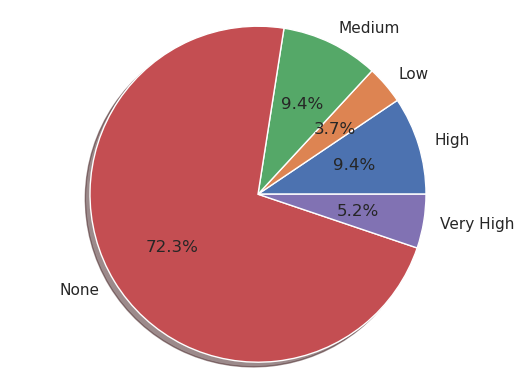

In [144]:
labels = energia_meteo['Injeção na rede (kWh)'].astype('category').cat.categories.tolist()
counts = energia_meteo['Injeção na rede (kWh)'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True)
ax1.axis('equal')
plt.show()

### a) weather_description

In [145]:
energia_meteo['weather_description'].unique()

array(['overcast clouds', 'broken clouds', 'few clouds', 'sky is clear',
       'scattered clouds', 'light rain', 'moderate rain',
       'heavy intensity rain'], dtype=object)

In [146]:
replace_map = {'weather_description':
               {'overcast clouds':0, 
                'broken clouds': 1,
                'few clouds': 2,
                'sky is clear': 3,
                'scattered clouds': 4,
                'light rain': 5,
                'moderate rain': 6,
                'heavy intensity rain': 7,}}

In [147]:
energia_meteo.replace(replace_map, inplace=True)
energia_meteo.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),temp,feels_like,temp_min,temp_max,...,weather_description,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana
0,2021-09-29,0,0.0,0.0,0.0,None,13.97,13.54,11.45,14.04,...,0,10.041354,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
1,2021-09-29,1,0.0,0.0,0.0,None,13.48,13.02,13.43,13.90,...,0,6.849467,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
2,2021-09-29,2,0.0,0.0,0.0,None,12.93,12.47,12.72,13.43,...,0,6.519877,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
3,2021-09-29,3,0.0,0.0,0.0,None,12.61,12.15,10.34,12.93,...,0,6.638072,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta
4,2021-09-29,4,0.0,0.0,0.0,None,12.61,12.17,9.79,12.93,...,0,6.379216,0.0,0.0,0.0,0.0,0.0,0.0,False,Quarta


### b) dia_da_semana

In [148]:
energia_meteo['dia_da_semana'].unique()

array(['Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo', 'Segunda',
       'Terça'], dtype=object)

In [149]:
import category_encoders as ce

encoder_model = ce.BinaryEncoder(cols=['dia_da_semana'])
df_binary = encoder_model.fit_transform(energia_meteo)
energia_meteo = df_binary
energia_meteo.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),temp,feels_like,temp_min,temp_max,...,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana_0,dia_da_semana_1,dia_da_semana_2
0,2021-09-29,0,0.0,0.0,0.0,None,13.97,13.54,11.45,14.04,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1
1,2021-09-29,1,0.0,0.0,0.0,None,13.48,13.02,13.43,13.90,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1
2,2021-09-29,2,0.0,0.0,0.0,None,12.93,12.47,12.72,13.43,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1
3,2021-09-29,3,0.0,0.0,0.0,None,12.61,12.15,10.34,12.93,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1
4,2021-09-29,4,0.0,0.0,0.0,None,12.61,12.17,9.79,12.93,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1


### c) Injeção na rede

- tem ordem
- modelo não intreperta essa ordem

1. Label encoding

In [150]:
energia_meteo_decimal = energia_meteo.copy()
energia_meteo_label = energia_meteo.copy()

In [151]:
replace_map={'Injeção na rede (kWh)': {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}}

In [152]:
energia_meteo_decimal.replace(replace_map, inplace=True)
energia_meteo_decimal.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),temp,feels_like,temp_min,temp_max,...,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana_0,dia_da_semana_1,dia_da_semana_2
0,2021-09-29,0,0.0,0.0,0.0,0,13.97,13.54,11.45,14.04,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1
1,2021-09-29,1,0.0,0.0,0.0,0,13.48,13.02,13.43,13.90,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1
2,2021-09-29,2,0.0,0.0,0.0,0,12.93,12.47,12.72,13.43,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1
3,2021-09-29,3,0.0,0.0,0.0,0,12.61,12.15,10.34,12.93,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1
4,2021-09-29,4,0.0,0.0,0.0,0,12.61,12.17,9.79,12.93,...,0.0,0.0,0.0,0.0,0.0,0.0,False,0,0,1


2. Separar por colunas

In [153]:
energia_meteo_label['None'] = np.where(energia_meteo_label['Injeção na rede (kWh)'].str.contains("None"), 1, 0)
energia_meteo_label['Low'] = np.where(energia_meteo_label['Injeção na rede (kWh)'].str.contains("Low"), 1, 0)
energia_meteo_label['Medium'] = np.where(energia_meteo_label['Injeção na rede (kWh)'].str.contains("Medium"), 1, 0)
energia_meteo_label['High'] = np.where(energia_meteo_label['Injeção na rede (kWh)'].str.contains("High"), 1, 0)
energia_meteo_label['Very_High'] = np.where(energia_meteo_label['Injeção na rede (kWh)'].str.contains("Very_High"), 1, 0)

In [154]:
energia_meteo_label.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),temp,feels_like,temp_min,temp_max,...,diffuse_radiation,feriado,dia_da_semana_0,dia_da_semana_1,dia_da_semana_2,None,Low,Medium,High,Very_High
0,2021-09-29,0,0.0,0.0,0.0,None,13.97,13.54,11.45,14.04,...,0.0,False,0,0,1,1,0,0,0,0
1,2021-09-29,1,0.0,0.0,0.0,None,13.48,13.02,13.43,13.90,...,0.0,False,0,0,1,1,0,0,0,0
2,2021-09-29,2,0.0,0.0,0.0,None,12.93,12.47,12.72,13.43,...,0.0,False,0,0,1,1,0,0,0,0
3,2021-09-29,3,0.0,0.0,0.0,None,12.61,12.15,10.34,12.93,...,0.0,False,0,0,1,1,0,0,0,0
4,2021-09-29,4,0.0,0.0,0.0,None,12.61,12.17,9.79,12.93,...,0.0,False,0,0,1,1,0,0,0,0


## Tratamento de Datas

In [155]:
energia_meteo_data = energia_meteo_decimal.copy()
# energia_meteo_data = energia_meteo_label.copy()
energia_meteo['Data'] = pd.to_datetime(energia_meteo['Data'], format='%Y-%m-%d', errors='coerce')
energia_meteo_data['Data'] = pd.to_datetime(energia_meteo_data['Data'], format='%Y-%m-%d', errors='coerce')

In [156]:
assert energia_meteo['Data'].isnull().sum() == 0, 'missing dates'
assert energia_meteo_data['Data'].isnull().sum() == 0, 'missing dates'

In [157]:
energia_meteo['Data'].head()

0   2021-09-29
1   2021-09-29
2   2021-09-29
3   2021-09-29
4   2021-09-29
Name: Data, dtype: datetime64[ns]

In [158]:
energia_meteo_data['Data'].head()

0   2021-09-29
1   2021-09-29
2   2021-09-29
3   2021-09-29
4   2021-09-29
Name: Data, dtype: datetime64[ns]

In [159]:
print(energia_meteo_data.dtypes)

Data                       datetime64[ns]
Hora                                int64
Normal (kWh)                      float64
Horário Económico (kWh)           float64
Autoconsumo (kWh)                 float64
Injeção na rede (kWh)               int64
temp                              float64
feels_like                        float64
temp_min                          float64
temp_max                          float64
pressure                            int64
humidity                            int64
wind_speed                        float64
clouds_all                          int64
weather_description                 int64
wind_speed_10m                    float32
is_day                            float32
sunshine_duration                 float32
direct_radiation                  float32
rain                              float32
shortwave_radiation               float32
diffuse_radiation                 float32
feriado                              bool
dia_da_semana_0                   

In [160]:
energia_meteo_data['year'] = energia_meteo_data['Data'].dt.year
energia_meteo_data['month'] = energia_meteo_data['Data'].dt.month
energia_meteo_data['day'] = energia_meteo_data['Data'].dt.day

In [161]:
energia_meteo_data.drop(['Data'], axis=1, inplace=True)

In [162]:
energia_meteo_data.head()

,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),temp,feels_like,temp_min,temp_max,pressure,...,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana_0,dia_da_semana_1,dia_da_semana_2,year,month,day
0,0,0.0,0.0,0.0,0,13.97,13.54,11.45,14.04,1027,...,0.0,0.0,0.0,False,0,0,1,2021,9,29
1,1,0.0,0.0,0.0,0,13.48,13.02,13.43,13.90,1028,...,0.0,0.0,0.0,False,0,0,1,2021,9,29
2,2,0.0,0.0,0.0,0,12.93,12.47,12.72,13.43,1027,...,0.0,0.0,0.0,False,0,0,1,2021,9,29
3,3,0.0,0.0,0.0,0,12.61,12.15,10.34,12.93,1027,...,0.0,0.0,0.0,False,0,0,1,2021,9,29
4,4,0.0,0.0,0.0,0,12.61,12.17,9.79,12.93,1027,...,0.0,0.0,0.0,False,0,0,1,2021,9,29


In [163]:
energia_meteo_data.describe()

,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),temp,feels_like,temp_min,temp_max,pressure,...,direct_radiation,rain,shortwave_radiation,diffuse_radiation,dia_da_semana_0,dia_da_semana_1,dia_da_semana_2,year,month,day
count,11688.000000,11016.000000,11016.000000,11016.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,...,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000,11688.000000
mean,11.500000,0.202278,0.159714,0.117314,0.715349,16.406638,16.076164,14.433353,17.502990,1018.304073,...,113.214577,0.211063,163.341370,50.126797,0.568789,0.570842,0.570842,2021.749487,7.523614,15.728953
std,6.922483,0.349478,0.271792,0.176762,1.256998,5.715977,6.217605,4.960590,6.112344,6.109727,...,198.140427,0.807710,246.070663,71.163231,0.495267,0.494977,0.494977,0.433327,3.493022,8.799320
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000,-2.190000,-0.640000,1.330000,994.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.000000,1.000000,1.000000
25%,5.750000,0.000000,0.000000,0.000000,0.000000,12.350000,11.760000,10.900000,12.930000,1015.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2021.000000,5.000000,8.000000
50%,11.500000,0.000000,0.000000,0.000000,0.000000,15.760000,15.675000,14.540000,16.720000,1018.000000,...,0.000000,0.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2022.000000,9.000000,16.000000
75%,17.250000,0.314000,0.288000,0.227000,1.000000,19.540000,19.560000,17.720000,20.700000,1022.000000,...,152.250000,0.000000,280.250000,88.000000,1.000000,1.000000,1.000000,2022.000000,11.000000,23.000000
max,23.000000,3.251000,6.978000,1.192000,4.000000,40.850000,41.330000,36.720000,41.450000,1034.000000,...,867.000000,16.799999,975.000000,407.000000,1.000000,1.000000,1.000000,2022.000000,12.000000,31.000000


In [164]:
energia_meteo_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 0 to 8759
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hora                     11688 non-null  int64  
 1   Normal (kWh)             11016 non-null  float64
 2   Horário Económico (kWh)  11016 non-null  float64
 3   Autoconsumo (kWh)        11016 non-null  float64
 4   Injeção na rede (kWh)    11688 non-null  int64  
 5   temp                     11688 non-null  float64
 6   feels_like               11688 non-null  float64
 7   temp_min                 11688 non-null  float64
 8   temp_max                 11688 non-null  float64
 9   pressure                 11688 non-null  int64  
 10  humidity                 11688 non-null  int64  
 11  wind_speed               11688 non-null  float64
 12  clouds_all               11688 non-null  int64  
 13  weather_description      11688 non-null  int64  
 14  wind_speed_10m           116

In [165]:
# UPsampling

# %pip install imblearn
# from imblearn.over_sampling import SMOTE

# # Separe as características (X) e o target (y)
# X = energia_meteo_data.drop('Injeção na rede (kWh)', axis=1)
# y = energia_meteo_data['Injeção na rede (kWh)']

# # Inicialize o SMOTE
# smote = SMOTE()

# # Aplique o SMOTE
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [166]:
# Downsampling

# label='Injeção na rede (kWh)'
# g = energia_meteo_data.groupby(label, group_keys=False)
# balanced_df = pd.DataFrame(g.apply(lambda x: 
# x.sample(g.size().min()))).reset_index(drop=True)

In [167]:
# print(balanced_df['Injeção na rede (kWh)'].value_counts())

In [168]:
# y_resampled_df = pd.DataFrame(y_resampled, columns=['Injeção na rede (kWh)'])
# df_resampled = pd.concat([X_resampled, y_resampled_df], axis=1)

In [169]:
# df_resampled.head()

In [170]:
# downsampling
# X = df.drop('Injeção', axis=1)
# y = df['Injeção']

# undersampler = RandomUnderSampler(random_state=2023)
# X_resampled, y_resampled = undersampler.fit_resample(X, y)

# df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
# df_resampled['Injeção'] = y_resampled

## Exploratory Data Analysis

In [171]:
energia_meteo = energia_meteo_data.copy()
energia_meteo.nunique()

Hora                         24
Normal (kWh)               1282
Horário Económico (kWh)     851
Autoconsumo (kWh)           752
Injeção na rede (kWh)         5
temp                       2423
feels_like                 2702
temp_min                    488
temp_max                    550
pressure                     41
humidity                     82
wind_speed                  771
clouds_all                  101
weather_description           8
wind_speed_10m             1386
is_day                        2
sunshine_duration           988
direct_radiation            822
rain                         91
shortwave_radiation         936
diffuse_radiation           365
feriado                       2
dia_da_semana_0               2
dia_da_semana_1               2
dia_da_semana_2               2
year                          2
month                        12
day                          31
dtype: int64

<Axes: >

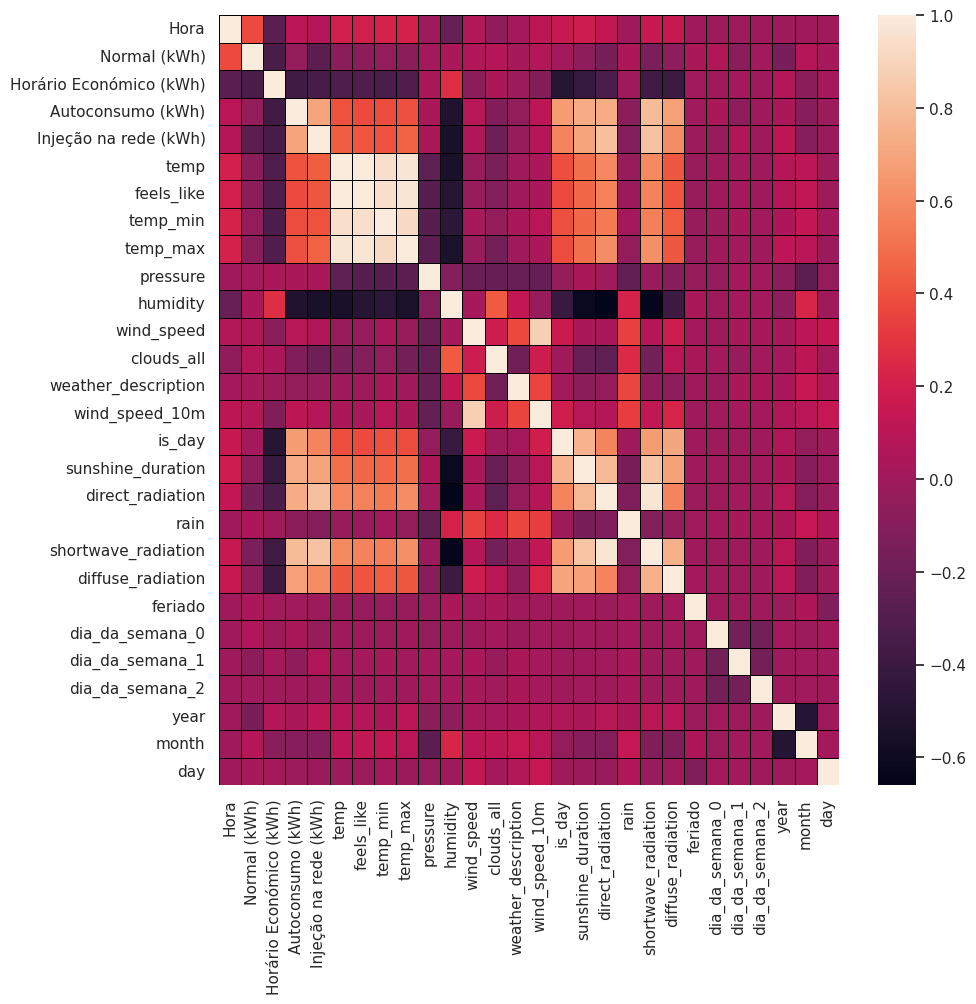

In [172]:
fig = plt.figure(figsize = (10,10))
incidents_corr = energia_meteo.corr(method='pearson')
sns.heatmap(incidents_corr,linecolor='black', linewidths=0.5)

- temp, feels_like, temp_min, temp_max são altamente correlacionadas, vamos explorá-las, visto que em princípio dá para manter apenas uma destas colunas - temp

In [173]:
energia_meteo.drop(['feels_like'], axis=1, inplace=True)
energia_meteo.drop(['temp_min'], axis=1, inplace=True)
energia_meteo.drop(['temp_max'], axis=1, inplace=True)

<Axes: >

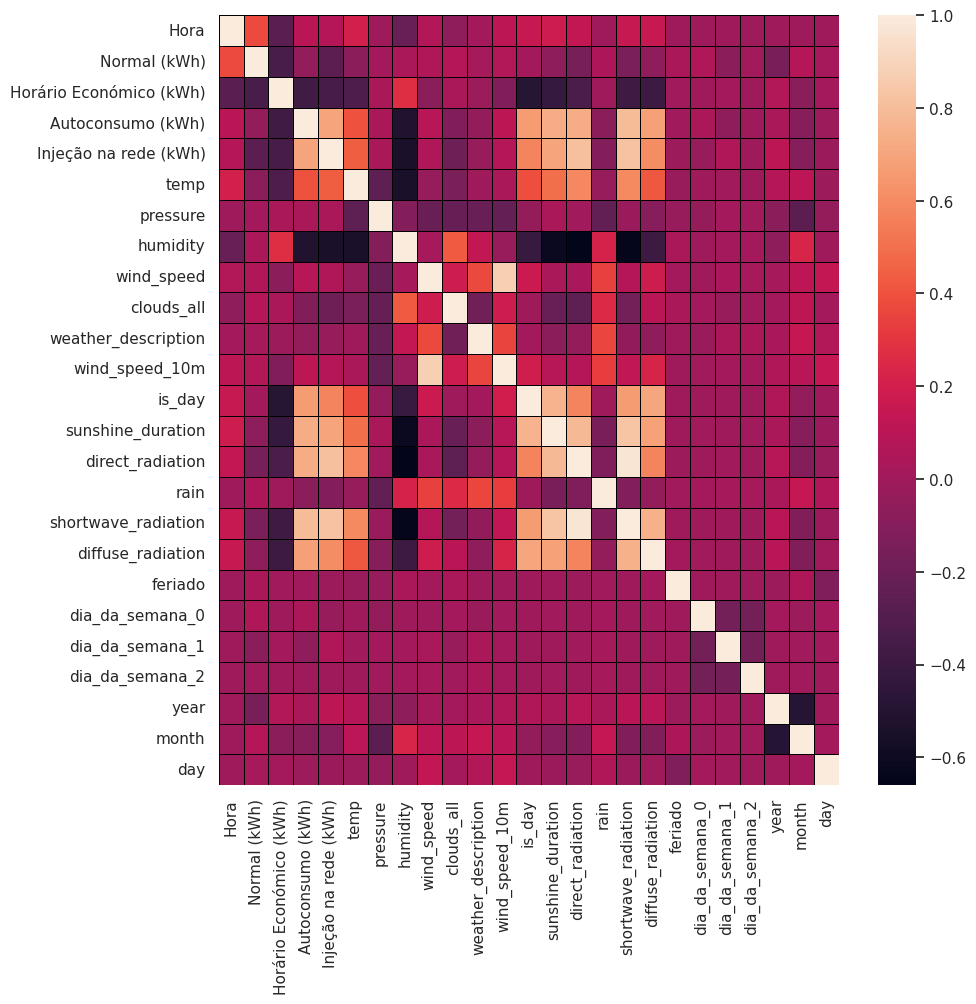

In [174]:
fig = plt.figure(figsize = (10,10))
incidents_corr = energia_meteo.corr(method='pearson')
sns.heatmap(incidents_corr,linecolor='black', linewidths=0.5)

- inversamente proporcionais: humidade com [autoconsumo, injeção na rede, temp]
- autoconsumo e injeção na rede são diretamente proporcionais

In [175]:
# sns.pairplot(energia_meteo)

### Joinplot para analisar humidade com autoconsumo

In [176]:
energia_meteo.head()

,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),temp,pressure,humidity,wind_speed,clouds_all,...,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana_0,dia_da_semana_1,dia_da_semana_2,year,month,day
0,0,0.0,0.0,0.0,0,13.97,1027,81,1.96,87,...,0.0,0.0,0.0,False,0,0,1,2021,9,29
1,1,0.0,0.0,0.0,0,13.48,1028,82,1.83,91,...,0.0,0.0,0.0,False,0,0,1,2021,9,29
2,2,0.0,0.0,0.0,0,12.93,1027,84,1.96,93,...,0.0,0.0,0.0,False,0,0,1,2021,9,29
3,3,0.0,0.0,0.0,0,12.61,1027,85,1.85,95,...,0.0,0.0,0.0,False,0,0,1,2021,9,29
4,4,0.0,0.0,0.0,0,12.61,1027,86,1.83,93,...,0.0,0.0,0.0,False,0,0,1,2021,9,29


In [177]:
energia_meteo.info()
energia_meteo.fillna(0,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 0 to 8759
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hora                     11688 non-null  int64  
 1   Normal (kWh)             11016 non-null  float64
 2   Horário Económico (kWh)  11016 non-null  float64
 3   Autoconsumo (kWh)        11016 non-null  float64
 4   Injeção na rede (kWh)    11688 non-null  int64  
 5   temp                     11688 non-null  float64
 6   pressure                 11688 non-null  int64  
 7   humidity                 11688 non-null  int64  
 8   wind_speed               11688 non-null  float64
 9   clouds_all               11688 non-null  int64  
 10  weather_description      11688 non-null  int64  
 11  wind_speed_10m           11688 non-null  float32
 12  is_day                   11688 non-null  float32
 13  sunshine_duration        11688 non-null  float32
 14  direct_radiation         116

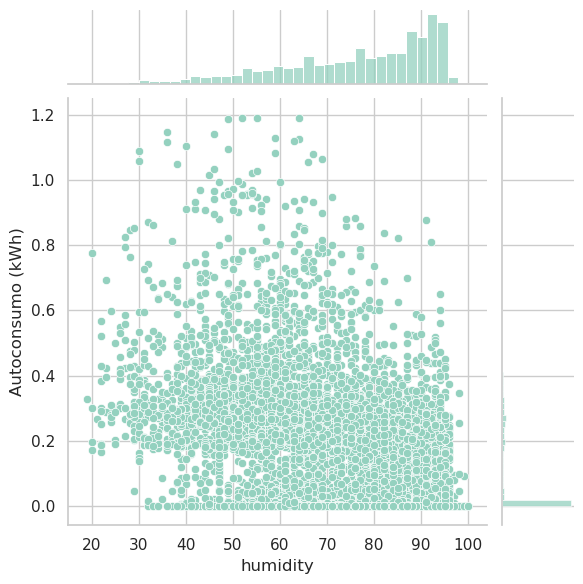

In [178]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.jointplot(x='humidity',y='Autoconsumo (kWh)',data=energia_meteo)

### Joinplot para analisar humidade com injeção de rede

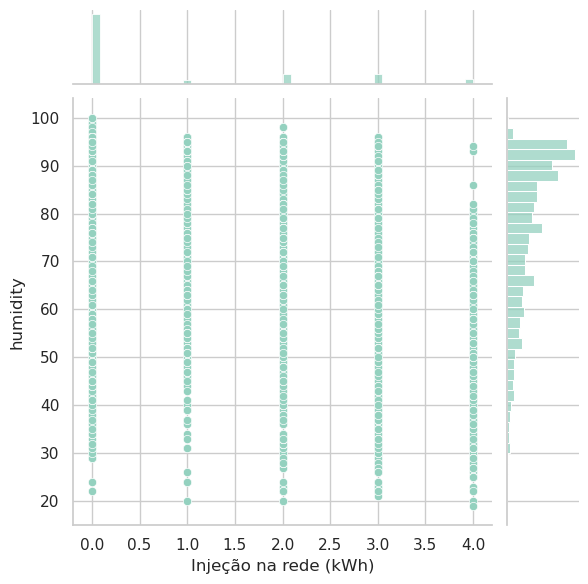

In [179]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.jointplot(x='Injeção na rede (kWh)',y='humidity',data=energia_meteo)

- tem uma humidade bem distribuida xD

### Joinplot para analisar humidade com temp

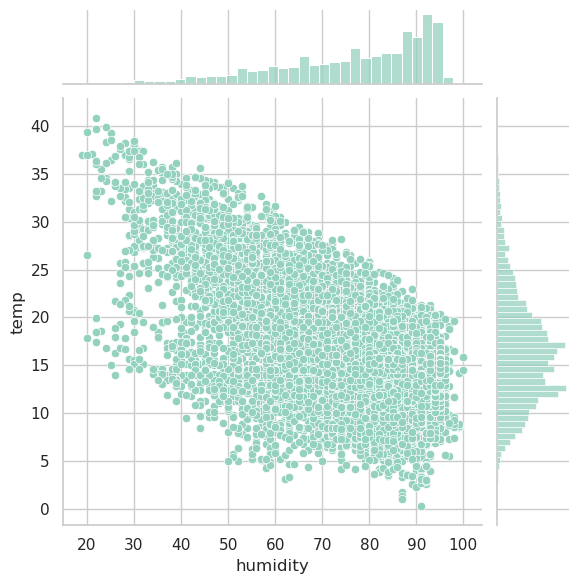

In [180]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.jointplot(x='humidity',y='temp',data=energia_meteo)

- com o aumento da humidade, a temperatura desce

### Joinplot para analisar injeção na rede com autoconsumo

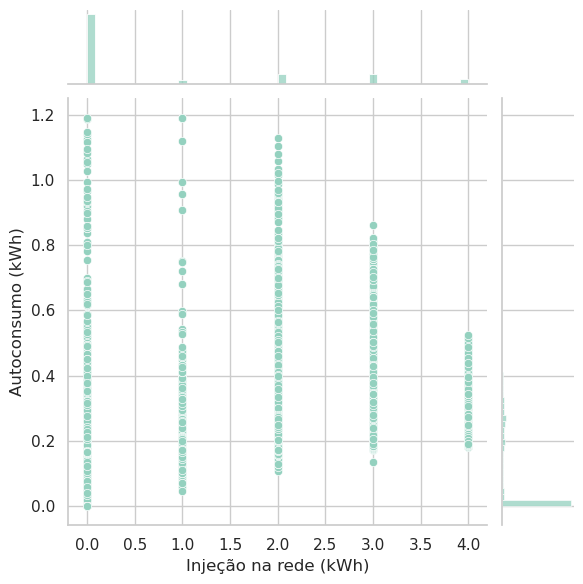

In [181]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.jointplot(x='Injeção na rede (kWh)',y='Autoconsumo (kWh)',data=energia_meteo)

In [182]:
energia_meteo.drop(['wind_speed'], axis=1, inplace=True)
# energia_meteo.drop(['humidity'], axis=1, inplace=True)

## Train Test Split

In [183]:
from sklearn.model_selection import train_test_split

In [184]:
energia_meteo.columns

Index(['Hora', 'Normal (kWh)', 'Horário Económico (kWh)', 'Autoconsumo (kWh)',
       'Injeção na rede (kWh)', 'temp', 'pressure', 'humidity', 'clouds_all',
       'weather_description', 'wind_speed_10m', 'is_day', 'sunshine_duration',
       'direct_radiation', 'rain', 'shortwave_radiation', 'diffuse_radiation',
       'feriado', 'dia_da_semana_0', 'dia_da_semana_1', 'dia_da_semana_2',
       'year', 'month', 'day'],
      dtype='object')

In [185]:
# energia_meteo.drop(['humidity'], axis=1, inplace=True)

In [186]:
X = energia_meteo.drop('Injeção na rede (kWh)', axis=1)
y = energia_meteo['Injeção na rede (kWh)']

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)

In [188]:
y_test.head()

1903    0
1837    3
2259    0
1721    0
5102    4
Name: Injeção na rede (kWh), dtype: int64

/tmp/ipykernel_29328/4282820180.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Injeção na rede (kWh)',data=aux,palette='RdBu_r')


<Axes: xlabel='Injeção na rede (kWh)', ylabel='count'>

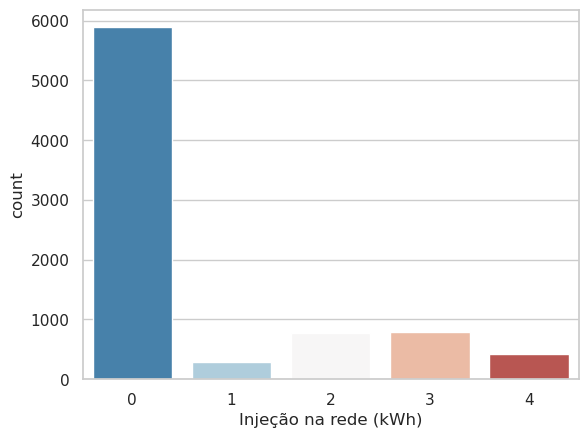

In [189]:
sns.set_style('whitegrid')
aux = pd.DataFrame(y_train,columns=['Injeção na rede (kWh)'])
sns.countplot(x='Injeção na rede (kWh)',data=aux,palette='RdBu_r')

In [190]:
# show number of values for each colunm of the train dataset
print(aux['Injeção na rede (kWh)'].value_counts())

Injeção na rede (kWh)
0    5891
3     794
2     774
4     427
1     295
Name: count, dtype: int64


/tmp/ipykernel_29328/3924753907.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Injeção na rede (kWh)',data=aux,palette='RdBu_r')


<Axes: xlabel='Injeção na rede (kWh)', ylabel='count'>

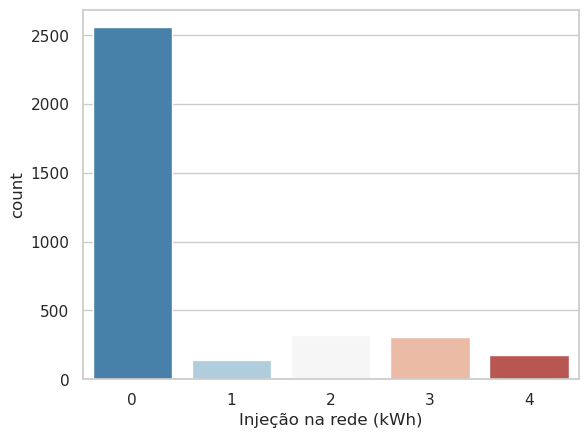

In [191]:
sns.set_style('whitegrid')
aux = pd.DataFrame(y_test,columns=['Injeção na rede (kWh)'])
sns.countplot(x='Injeção na rede (kWh)',data=aux,palette='RdBu_r')

In [192]:
print(aux['Injeção na rede (kWh)'].value_counts())

Injeção na rede (kWh)
0    2558
2     324
3     309
4     179
1     137
Name: count, dtype: int64


como os racios estão praticamente iguais, é uma boa partição

## Support Vector Machine

### Set up the dataframe

In [1105]:
energia_meteo['Injeção na rede (kWh)']

0       0
1       0
2       0
3       0
4       0
       ..
8755    0
8756    0
8757    0
8758    0
8759    0
Name: Injeção na rede (kWh), Length: 11688, dtype: int64

In [1106]:
df_target = pd.DataFrame(energia_meteo['Injeção na rede (kWh)'])

df_target.head()

,Injeção na rede (kWh)
0,0
1,0
2,0
3,0
4,0


## Train the Support Vector Classifier

#### 10-Fold Cross Validation

In [1107]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [1108]:
energia_meteo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11688 entries, 0 to 8759
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hora                     11688 non-null  int64  
 1   Normal (kWh)             11688 non-null  float64
 2   Horário Económico (kWh)  11688 non-null  float64
 3   Autoconsumo (kWh)        11688 non-null  float64
 4   Injeção na rede (kWh)    11688 non-null  int64  
 5   temp                     11688 non-null  float64
 6   pressure                 11688 non-null  int64  
 7   humidity                 11688 non-null  int64  
 8   clouds_all               11688 non-null  int64  
 9   weather_description      11688 non-null  int64  
 10  wind_speed_10m           11688 non-null  float32
 11  is_day                   11688 non-null  float32
 12  sunshine_duration        11688 non-null  float32
 13  direct_radiation         11688 non-null  float32
 14  rain                     116

In [1109]:
# TODO - testar cv
cross_valid_model = SVC(random_state=2023)
scores = cross_val_score(cross_valid_model, energia_meteo, np.ravel(df_target), cv=10)
scores

array([0.77758768, 0.76817793, 0.66723695, 0.81437126, 0.80838323,
       0.79982891, 0.80923867, 0.82549187, 0.8005137 , 0.78339041])

In [1110]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.79 accuracy with a standard deviation of 0.04


And now without Cross Validation:

In [1111]:
model = SVC(random_state=2023)

In [1112]:
model.fit(X_train, y_train)

SVC(random_state=2023)

### Predictions and evaluations

In [1113]:
predictions = model.predict(X_test)

In [1114]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

In [1115]:
print("%0.2f accuracy" % accuracy_score(y_test,predictions))

0.80 accuracy


In [1116]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2558
           1       0.00      0.00      0.00       137
           2       0.48      0.09      0.15       324
           3       0.48      0.60      0.53       309
           4       0.58      0.60      0.59       179

    accuracy                           0.80      3507
   macro avg       0.48      0.45      0.44      3507
weighted avg       0.75      0.80      0.76      3507



/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

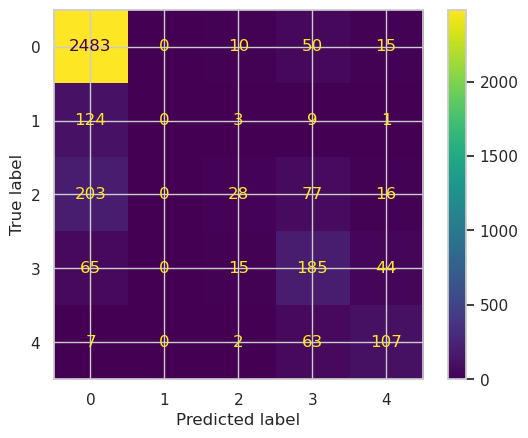

In [1117]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions)
plt.show()

## Artificial Neural Network

### EDA

In [1118]:
# %pip install tensorflow
# %pip install --upgrade keras
# %pip install scikeras[tensorflow]

In [1119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense#, Dropout, BatchNormalization
from scikeras.wrappers import KerasRegressor#, KerasClassifier

### Structure the MLP

In [1120]:
def build_model(activation = 'relu', learning_rate = 0.01):
    model = Sequential()
    model.add(Dense(16, input_dim = 5, activation = activation))
    model.add(Dense(8, activation = activation))
    model.add(Dense(1, activation = activation)) #output
    
    #Compile the model
    model.compile(
        loss = 'mae',
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ['mae', 'mse']      
    )
    
    return model

Build the model:

In [1121]:
model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 16)                96        
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


### GridSearchCV

In [1122]:
from sklearn.model_selection import GridSearchCV, KFold

In [1123]:
optimizer = ['SGD', 'RMSprop', 'Adagrad']
param_grid = dict(optimizer = optimizer)

In [1124]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 2021)

In [1125]:
model = KerasRegressor(model = build_model, batch_size = 32, validation_split = 0.2, epochs = 20)

In [1126]:
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = kf, scoring = 'neg_mean_absolute_error', refit = 'True', verbose = 1)

In [1127]:
# grid_search.fit(X_train, y_train)

Best results

In [1128]:
# print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))

In [1129]:
# means = grid_search.cv_results_['mean_test_score']
# stds = grid_search.cv_results_['std_test_score']
# params = grid_search.cv_results_['params']

In [1130]:
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [1131]:
# best_mlp_model = grid_search.best_estimator_
# print(best_mlp_model)

Use the best model

In [1132]:
# best_mlp_model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), verbose = 1)

In [1133]:
# plt.plot(best_mlp_model.history_['loss'])
# plt.plot(best_mlp_model.history_['val_loss'])
# plt.title('model performance')
# plt.ylabel('loss values')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [1134]:
# pd.DataFrame(best_mlp_model.history_).plot(figsize = (8, 5))
# plt.show()

Predictions

In [1135]:
# predictions = best_mlp_model.predict(X_test)

In [1136]:
# print(predictions[:5])

Evaluate the model

In [1137]:
# from sklearn import metrics

In [1138]:
# print('MAE:', metrics.mean_absolute_error(y_test, predictions))
# print('MSE:', metrics.mean_squared_error(y_test, predictions))
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [1139]:
# plt.scatter(y_test, predictions)

In [1140]:
# def real_predicted_viz(limit):
#     plt.figure(figsize = (14, 6))
#     plt.plot(y_test[:limit], color = 'green', label = 'Actual')
#     plt.plot(predictions[:limit], color = 'red', label = 'Predicted')
#     plt.grid(alpha = 0.3)
#     plt.xlabel('Houses')
#     plt.ylabel('Price')
#     plt.title('Real vs Predicted')
#     plt.legend()
#     plt.show()

In [1141]:
# real_predicted_viz(200)

## Decision Tree

In [1142]:
from sklearn.tree import DecisionTreeClassifier

In [1143]:
dt_model = DecisionTreeClassifier(random_state=2023, class_weight='balanced', max_depth=30)
# criterion='gini',
# splitter='best',
# max_depth=None,
# min_samples_split=2,
# min_samples_leaf=1,
# max_features=None,
# max_leaf_nodes=None,
# min_impurity_decrease=0.0

In [1144]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=30, random_state=2023)

In [1145]:
dt_score = dt_model.score(X_test, y_test)

In [1146]:
print("Accuracy: %0.2f" % (dt_score*100))

Accuracy: 86.31


In [1147]:
dt_predictions = dt_model.predict(X_test)

In [1148]:
print(classification_report(y_test, dt_predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2558
           1       0.32      0.28      0.30       137
           2       0.54      0.50      0.52       324
           3       0.65      0.67      0.66       309
           4       0.72      0.75      0.73       179

    accuracy                           0.86      3507
   macro avg       0.64      0.63      0.64      3507
weighted avg       0.86      0.86      0.86      3507



In [1149]:
results = {'DT': dt_score}

## Support Vector Machine

In [1150]:
svm_model = SVC(random_state=2022)

In [1151]:
svm_model.fit(X_train, y_train)

SVC(random_state=2022)

In [1152]:
svm_score = svm_model.score(X_test, y_test)

In [1153]:
print("Accuracy: %.2f%%" % (svm_score * 100))

Accuracy: 79.93%


In [1154]:
svm_predictions = svm_model.predict(X_test)

In [1155]:
print(classification_report(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2558
           1       0.00      0.00      0.00       137
           2       0.48      0.09      0.15       324
           3       0.48      0.60      0.53       309
           4       0.58      0.60      0.59       179

    accuracy                           0.80      3507
   macro avg       0.48      0.45      0.44      3507
weighted avg       0.75      0.80      0.76      3507



/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [1156]:
results['SVM'] = svm_score

## Bagging

In [1157]:
sss = StratifiedShuffleSplit(n_splits=15, test_size=0.30, random_state=2023)

In [1158]:
bg_model = BaggingClassifier(estimator=dt_model, bootstrap=True, random_state=2023, oob_score=True)

In [1159]:
n_estimators = [10,40,60,80,100,250]

In [1160]:
parameters = {'n_estimators': n_estimators}

In [1161]:
grid_bg = GridSearchCV(estimator = bg_model, param_grid = parameters, cv = sss)

In [1162]:
grid_bg.fit(X_train, y_train)

/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/s

/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/s

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=15, random_state=2023, test_size=0.3,
            train_size=None),
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                          max_depth=30,
                                                                          random_state=2023),
                                         oob_score=True, random_state=2023),
             param_grid={'n_estimators': [10, 40, 60, 80, 100, 250]})

In [1163]:
bst_bg_model = grid_bg.best_estimator_

In [1164]:
print(bst_bg_model)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_depth=30,
                                                   random_state=2023),
                  n_estimators=250, oob_score=True, random_state=2023)


In [1165]:
bst_bg_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                   max_depth=30,
                                                   random_state=2023),
                  n_estimators=250, oob_score=True, random_state=2023)

In [1166]:
bst_bg_score = bst_bg_model.score(X_test, y_test)

In [1167]:
print("Accuracy: %.2f%%" % (bst_bg_score *100))

Accuracy: 89.54%


In [1168]:
bg_predictions = bst_bg_model.predict(X_test)

In [1169]:
print(classification_report(y_test, bg_predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2558
           1       0.50      0.22      0.30       137
           2       0.63      0.69      0.66       324
           3       0.72      0.74      0.73       309
           4       0.81      0.79      0.80       179

    accuracy                           0.90      3507
   macro avg       0.73      0.69      0.69      3507
weighted avg       0.89      0.90      0.89      3507



In [1170]:
results['Bagg']= bst_bg_score

## Random Forest

In [1171]:
rf_model = RandomForestClassifier(bootstrap=False, max_depth=2, verbose=1)

In [1172]:
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=False, max_depth=2, verbose=1)

In [1173]:
rf_score = rf_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1174]:
print("Accuracy: %.2f%%" % (rf_score * 100))

Accuracy: 82.52%


In [1175]:
rf_predictions = rf_model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1176]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2558
           1       0.00      0.00      0.00       137
           2       0.59      0.33      0.43       324
           3       0.47      0.88      0.61       309
           4       0.00      0.00      0.00       179

    accuracy                           0.83      3507
   macro avg       0.40      0.44      0.40      3507
weighted avg       0.76      0.83      0.78      3507



/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [1177]:
results['RF'] = rf_score

## Boosting

### Gradient Boosting

In [1178]:
gbc_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=2022)

In [1179]:
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=2022)

In [1180]:
gbc_score = gbc_model.score(X_test, y_test)

In [1181]:
print("Accuracy: %.2f%%" % (gbc_score * 100))

Accuracy: 80.72%


In [1182]:
gbc_predictions = gbc_model.predict(X_test)

In [1183]:
print(classification_report(y_test, gbc_predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2558
           1       0.38      0.26      0.31       137
           2       0.34      0.78      0.47       324
           3       0.60      0.25      0.35       309
           4       0.00      0.00      0.00       179

    accuracy                           0.81      3507
   macro avg       0.46      0.45      0.42      3507
weighted avg       0.81      0.81      0.79      3507



/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritavaz02/miniconda3/envs/daa/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [1184]:
results['GB'] = gbc_score

### XGBoost

In [193]:
xgb_model = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', num_class=5, random_state=2022)

In [194]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [195]:
xgb_score = xgb_model.score(X_test, y_test)

In [196]:
print("Accuracy: %.2f%%" % (xgb_score * 100))

Accuracy: 90.36%


In [197]:
xgb_predictions = xgb_model.predict(X_test)

In [198]:
print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2558
           1       0.49      0.31      0.38       137
           2       0.66      0.68      0.67       324
           3       0.75      0.79      0.77       309
           4       0.85      0.83      0.84       179

    accuracy                           0.90      3507
   macro avg       0.74      0.72      0.73      3507
weighted avg       0.90      0.90      0.90      3507



In [199]:
results['XGB'] = xgb_score

NameError: name 'results' is not defined

### XGBoost com gridSearch

In [200]:
parameters = {'n_estimators': [50,75,100], 'max_depth': [3,5], 'learning_rate': [0.1,0.01], 'subsample': [0.8,0.9], 'colsample_bytree': [0.9,1.0], 'gamma': [0,0.1], 'min_child_weight': [1,2], 'reg_alpha': [0,0.1], 'reg_lambda': [0,0.1]}

In [201]:
grid_xgb = GridSearchCV(estimator = xgb_model, param_grid = parameters, cv = 5, scoring = 'accuracy', n_jobs=-1)

In [202]:
grid_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=5,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.9, 1.0], 'gamma': [0, 0.1],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'min_child_weight': [1, 2],
                         'n_estimators': [50, 75, 100], 'reg_alpha': [0, 0.1],
                         'reg_lambda': [0, 0.1], 'subsample': [0.8, 0.9]},
             scoring='accuracy')

In [203]:
best_params = grid_xgb.best_params_

In [204]:
best_model = grid_xgb.best_estimator_

In [205]:
y_pred = best_model.predict(X_test)

In [206]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2558
           1       0.51      0.23      0.31       137
           2       0.66      0.70      0.68       324
           3       0.75      0.79      0.77       309
           4       0.84      0.84      0.84       179

    accuracy                           0.90      3507
   macro avg       0.75      0.71      0.72      3507
weighted avg       0.90      0.90      0.90      3507



In [207]:
results['XGB_Grid'] = best_model.score(X_test, y_test)

NameError: name 'results' is not defined

## Stacking

In [1200]:
estimators = [("dt", dt_model), ("svm", svm_model), ("rf", rf_model)]

In [1201]:
st_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [1202]:
st_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=30,
                                                       random_state=2023)),
                               ('svm', SVC(random_state=2022)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=2,
                                                       verbose=1))],
                   final_estimator=LogisticRegression())

In [1203]:
st_score = st_model.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1204]:
print("Accuracy: %.2f%%" % (st_score * 100))

Accuracy: 87.20%


In [1205]:
st_predictions = st_model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1206]:
print(classification_report(y_test, st_predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2558
           1       0.35      0.16      0.22       137
           2       0.57      0.57      0.57       324
           3       0.67      0.71      0.69       309
           4       0.78      0.72      0.75       179

    accuracy                           0.87      3507
   macro avg       0.66      0.63      0.64      3507
weighted avg       0.86      0.87      0.86      3507



In [1207]:
results['Stack']= st_score

## Max Voting

In [1208]:
hvt_model = VotingClassifier(estimators=estimators, voting='hard', weights=[2, 1, 2])

In [1209]:
hvt_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=30,
                                                     random_state=2023)),
                             ('svm', SVC(random_state=2022)),
                             ('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=2, verbose=1))],
                 weights=[2, 1, 2])

In [1210]:
for model, label in zip([dt_model,svm_model,rf_model,hvt_model], ['dt', 'svm', 'rf', 'Ensemble']):
    hvt_score = cross_val_score(model, X_test, y_test, scoring = 'accuracy', cv = 5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (hvt_score.mean(), hvt_score.std(), label))

Accuracy: 0.86 (+/- 0.01) [dt]
Accuracy: 0.79 (+/- 0.00) [svm]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Accuracy: 0.82 (+/- 0.01) [rf]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Accuracy: 0.84 (+/- 0.00) [Ensemble]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1211]:
hvt_score = hvt_model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (hvt_score * 100))

Accuracy: 84.97%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1212]:
hvt_predictions = hvt_model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [1213]:
print(classification_report(y_test, hvt_predictions))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2558
           1       0.24      0.06      0.09       137
           2       0.63      0.31      0.41       324
           3       0.58      0.82      0.68       309
           4       0.87      0.55      0.67       179

    accuracy                           0.85      3507
   macro avg       0.64      0.54      0.56      3507
weighted avg       0.83      0.85      0.83      3507



In [1214]:
results['HVotW']= hvt_score

## Models accuracy comparison

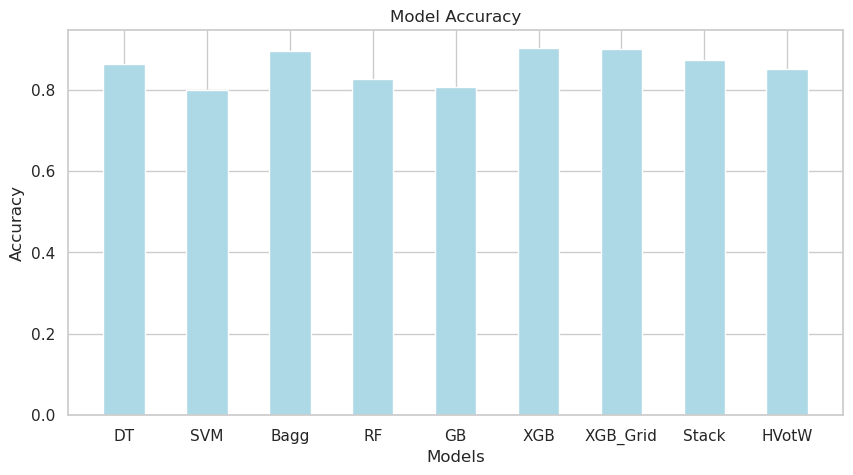

In [1215]:
fig = plt.figure(figsize=(10, 5))
mod = list(results.keys())
acc = list(results.values())
plt.bar(mod, acc, color ='lightblue', width = 0.5)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.show()

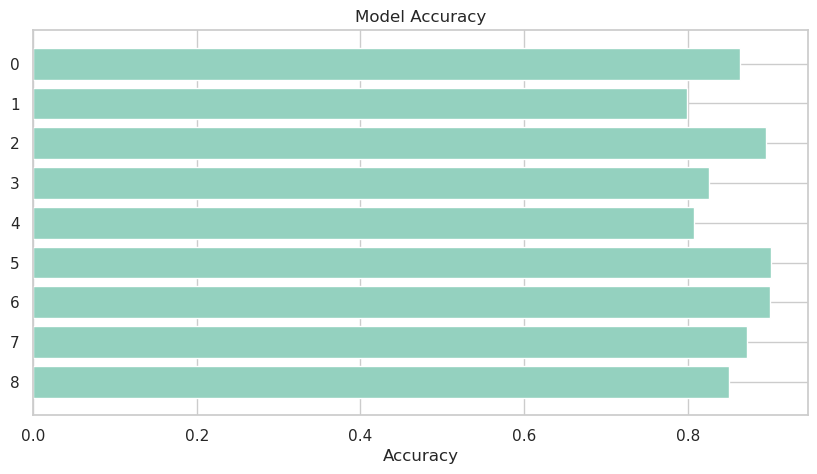

In [1216]:
fig, ax = plt.subplots(figsize=(10, 5))
y_vals = np.arange(len(mod))
ax.barh(y_vals, acc, align='center')
ax.set_yticks(y_vals)
ax.invert_yaxis()
ax.set_xlabel('Accuracy')
ax.set_title('Model Accuracy')
plt.show()

In [1217]:
print('Models Accuracy: ')
for k, v in results.items():
    print("%s \t %.2f" % (k, v))

Models Accuracy: 
DT 	 0.86
SVM 	 0.80
Bagg 	 0.90
RF 	 0.83
GB 	 0.81
XGB 	 0.90
XGB_Grid 	 0.90
Stack 	 0.87
HVotW 	 0.85


# Modelo

In [244]:
df_energia = pd.read_csv('daasbstp2023/energia_202301-202304.csv', encoding='latin-1')
df_meteoo = pd.read_csv('daasbstp2023/meteo_202301-202304.csv', encoding='latin-1')

In [245]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.5503,
	"longitude": -8.42,
	"start_date": "2023-01-01",
	"end_date": "2023-03-14",
	"hourly": ["wind_speed_10m", "is_day", "sunshine_duration", "direct_radiation", "rain", "shortwave_radiation","diffuse_radiation"],
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_wind_speed_10m = hourly.Variables(0).ValuesAsNumpy()
hourly_is_day = hourly.Variables(1).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(2).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(5).ValuesAsNumpy()
hourly_diffuse_radiation = hourly.Variables(6).ValuesAsNumpy()

hourly_data = {}
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["is_day"] = hourly_is_day
hourly_data["sunshine_duration"] = hourly_sunshine_duration
hourly_data["direct_radiation"] = hourly_direct_radiation
hourly_data["rain"] = hourly_rain
hourly_data["shortwave_radiation"] = hourly_shortwave_radiation
hourly_data["diffuse_radiation"] = hourly_diffuse_radiation

hourly_dataframe = pd.DataFrame(data = hourly_data)
df_meteo = pd.concat([df_meteoo, hourly_dataframe], axis=1)
df_meteo.info()

Coordinates 41.581722259521484°E -8.441558837890625°N
Elevation 193.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   1752 non-null   int64  
 1   dt_iso               1752 non-null   object 
 2   city_name            1752 non-null   object 
 3   temp                 1752 non-null   float64
 4   feels_like           1752 non-null   float64
 5   temp_min             1752 non-null   float64
 6   temp_max             1752 non-null   float64
 7   pressure             1752 non-null   int64  
 8   sea_level            0 non-null      float64
 9   grnd_level           0 non-null      float64
 10  humidity             1752 non-null   int64  
 11  wind_speed           1752 non-null   float64
 12  rain_1h              206 non-null    float64
 13  clouds_all

In [246]:
for column in df_meteo.columns:
    print(f"Valores da coluna {column}:")
    print(df_meteo[column].value_counts())

Valores da coluna dt:
dt
1672531200    1
1676721600    1
1676761200    1
1676757600    1
1676754000    1
             ..
1674619200    1
1674615600    1
1674612000    1
1674608400    1
1678834800    1
Name: count, Length: 1752, dtype: int64
Valores da coluna dt_iso:
dt_iso
2023-01-01 00:00:00 +0000 UTC    1
2023-02-18 12:00:00 +0000 UTC    1
2023-02-18 23:00:00 +0000 UTC    1
2023-02-18 22:00:00 +0000 UTC    1
2023-02-18 21:00:00 +0000 UTC    1
                                ..
2023-01-25 04:00:00 +0000 UTC    1
2023-01-25 03:00:00 +0000 UTC    1
2023-01-25 02:00:00 +0000 UTC    1
2023-01-25 01:00:00 +0000 UTC    1
2023-03-14 23:00:00 +0000 UTC    1
Name: count, Length: 1752, dtype: int64
Valores da coluna city_name:
city_name
local    1752
Name: count, dtype: int64
Valores da coluna temp:
temp
12.98    18
13.49    16
14.59    14
12.91    12
12.40    11
         ..
1.22      1
3.04      1
6.76      1
9.79      1
16.25     1
Name: count, Length: 889, dtype: int64
Valores da coluna feel

In [247]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt                   1752 non-null   int64  
 1   dt_iso               1752 non-null   object 
 2   city_name            1752 non-null   object 
 3   temp                 1752 non-null   float64
 4   feels_like           1752 non-null   float64
 5   temp_min             1752 non-null   float64
 6   temp_max             1752 non-null   float64
 7   pressure             1752 non-null   int64  
 8   sea_level            0 non-null      float64
 9   grnd_level           0 non-null      float64
 10  humidity             1752 non-null   int64  
 11  wind_speed           1752 non-null   float64
 12  rain_1h              206 non-null    float64
 13  clouds_all           1752 non-null   int64  
 14  weather_description  1752 non-null   object 
 15  wind_speed_10m       1752 non-null   f

In [248]:
df_energia.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh)
0,2023-01-01,0,0.0,0.467,0.0
1,2023-01-01,1,0.0,0.577,0.0
2,2023-01-01,2,0.0,0.346,0.0
3,2023-01-01,3,0.0,0.270,0.0
4,2023-01-01,4,0.0,0.252,0.0


In [249]:
df_meteo['Data'] = df_meteo['dt_iso'].str[:10]
df_meteo['Hora'] = df_meteo['dt_iso'].str[11:13].astype(int)

In [250]:
df_meteo.head()

,dt,dt_iso,city_name,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,...,weather_description,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,Data,Hora
0,1672531200,2023-01-01 00:00:00 +0000 UTC,local,12.93,12.76,12.72,13.43,1019,NaN,NaN,...,moderate rain,9.779817,0.0,0.0,0.0,3.7,0.0,0.0,2023-01-01,0
1,1672534800,2023-01-01 01:00:00 +0000 UTC,local,13.49,13.38,13.43,13.90,1018,NaN,NaN,...,moderate rain,11.874544,0.0,0.0,0.0,5.7,0.0,0.0,2023-01-01,1
2,1672538400,2023-01-01 02:00:00 +0000 UTC,local,13.55,13.44,13.48,14.82,1017,NaN,NaN,...,moderate rain,9.531505,0.0,0.0,0.0,8.7,0.0,0.0,2023-01-01,2
3,1672542000,2023-01-01 03:00:00 +0000 UTC,local,13.61,13.51,12.01,14.82,1016,NaN,NaN,...,moderate rain,12.074766,0.0,0.0,0.0,10.2,0.0,0.0,2023-01-01,3
4,1672545600,2023-01-01 04:00:00 +0000 UTC,local,13.59,13.49,12.01,14.82,1015,NaN,NaN,...,moderate rain,25.919998,0.0,0.0,0.0,2.6,0.0,0.0,2023-01-01,4


In [251]:
df_meteo.drop(['rain_1h'], axis=1, inplace=True)
df_meteo.drop(['feels_like'], axis=1, inplace=True)
df_meteo.drop(['temp_min'], axis=1, inplace=True)
df_meteo.drop(['temp_max'], axis=1, inplace=True)

<Axes: >

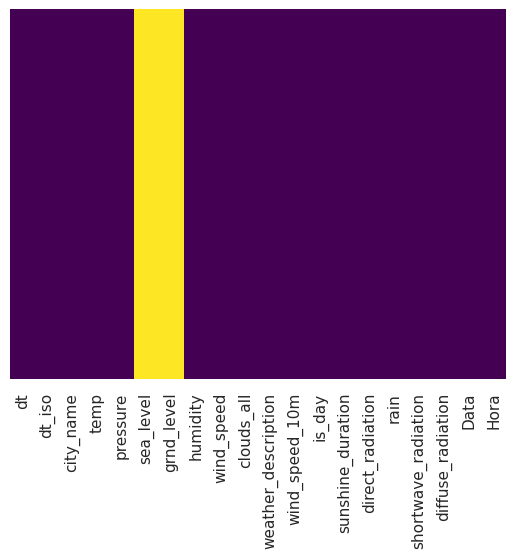

In [252]:
sns.heatmap(df_meteo.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [253]:
df_meteo.drop(['city_name'], axis=1, inplace=True)
df_meteo.drop(['sea_level','grnd_level'],axis=1,inplace=True)

In [254]:
df_meteo.fillna(0,inplace=True)

In [255]:
result = pd.merge(df_energia, df_meteo, on=["Data", "Hora"], how='outer')

In [256]:
result['temp'] = result['temp'].astype(float)
result['pressure'] = result['pressure'].astype(float)


In [257]:
def eh_feriado(data):
    pt_holidays = holidays.Portugal()
    return data in pt_holidays

# Convertendo a coluna de data para o tipo datetime e garantindo o formato correto
result['Data'] = pd.to_datetime(result['Data'], format='%Y-%m-%d')

# Adicionando a coluna de feriado
result['feriado'] = result['Data'].apply(eh_feriado)

# Adicionando a coluna do dia da semana
result['dia_da_semana'] = result['Data'].dt.day_name(locale='pt_PT')

result.head()

,Data,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),dt,dt_iso,temp,pressure,humidity,...,weather_description,wind_speed_10m,is_day,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana
0,2023-01-01,0,0.0,0.467,0.0,1.672531e+09,2023-01-01 00:00:00 +0000 UTC,12.93,1019.0,95.0,...,moderate rain,9.779817,0.0,0.0,0.0,3.7,0.0,0.0,True,Domingo
1,2023-01-01,1,0.0,0.577,0.0,1.672535e+09,2023-01-01 01:00:00 +0000 UTC,13.49,1018.0,95.0,...,moderate rain,11.874544,0.0,0.0,0.0,5.7,0.0,0.0,True,Domingo
2,2023-01-01,2,0.0,0.346,0.0,1.672538e+09,2023-01-01 02:00:00 +0000 UTC,13.55,1017.0,95.0,...,moderate rain,9.531505,0.0,0.0,0.0,8.7,0.0,0.0,True,Domingo
3,2023-01-01,3,0.0,0.270,0.0,1.672542e+09,2023-01-01 03:00:00 +0000 UTC,13.61,1016.0,95.0,...,moderate rain,12.074766,0.0,0.0,0.0,10.2,0.0,0.0,True,Domingo
4,2023-01-01,4,0.0,0.252,0.0,1.672546e+09,2023-01-01 04:00:00 +0000 UTC,13.59,1015.0,95.0,...,moderate rain,25.919998,0.0,0.0,0.0,2.6,0.0,0.0,True,Domingo


In [258]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Data                     2256 non-null   datetime64[ns]
 1   Hora                     2256 non-null   int64         
 2   Normal (kWh)             2256 non-null   float64       
 3   Horário Económico (kWh)  2256 non-null   float64       
 4   Autoconsumo (kWh)        2256 non-null   float64       
 5   dt                       1752 non-null   float64       
 6   dt_iso                   1752 non-null   object        
 7   temp                     1752 non-null   float64       
 8   pressure                 1752 non-null   float64       
 9   humidity                 1752 non-null   float64       
 10  wind_speed               1752 non-null   float64       
 11  clouds_all               1752 non-null   float64       
 12  weather_description      1752 non-

<Axes: >

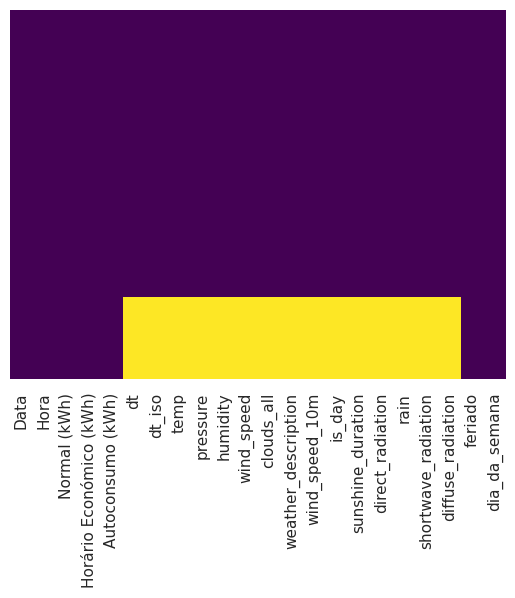

In [259]:
sns.heatmap(result.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [260]:
result.drop(['dt_iso'], axis=1, inplace=True)
result.drop(['dt'], axis=1, inplace=True)

In [261]:
replace_map = {'weather_description':
               {'overcast clouds':0, 
                'broken clouds': 1,
                'few clouds': 2,
                'sky is clear': 3,
                'scattered clouds': 4,
                'light rain': 5,
                'moderate rain': 6,
                'heavy intensity rain': 7,}}
result.replace(replace_map, inplace=True)

In [262]:
result['Data'] = pd.to_datetime(result['Data'], format='%Y-%m-%d', errors='coerce')

In [263]:
result['year'] = result['Data'].dt.year
result['month'] = result['Data'].dt.month
result['day'] = result['Data'].dt.day

In [264]:
result.drop(['Data'], axis=1, inplace=True)

In [265]:
result.drop(['wind_speed'], axis=1, inplace=True)
# result.drop(['humidity'], axis=1, inplace=True)

<Axes: >

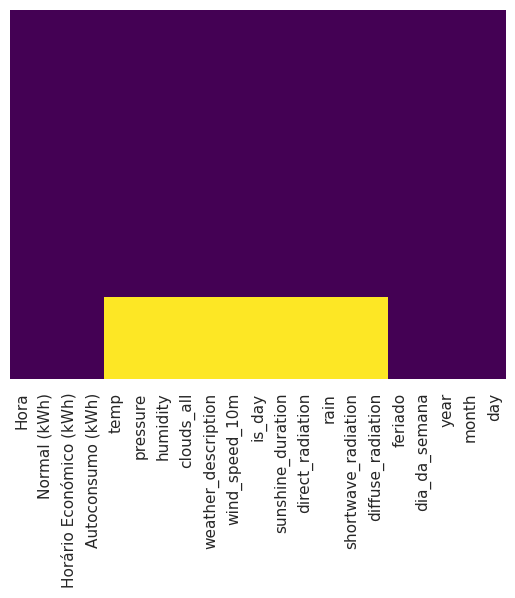

In [266]:
sns.heatmap(result.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [267]:
result.head()
result

,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),temp,pressure,humidity,clouds_all,weather_description,wind_speed_10m,...,sunshine_duration,direct_radiation,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana,year,month,day
0,0,0.000,0.467,0.000,12.93,1019.0,95.0,100.0,6.0,9.779817,...,0.0,0.0,3.7,0.0,0.0,True,Domingo,2023,1,1
1,1,0.000,0.577,0.000,13.49,1018.0,95.0,100.0,6.0,11.874544,...,0.0,0.0,5.7,0.0,0.0,True,Domingo,2023,1,1
2,2,0.000,0.346,0.000,13.55,1017.0,95.0,100.0,6.0,9.531505,...,0.0,0.0,8.7,0.0,0.0,True,Domingo,2023,1,1
3,3,0.000,0.270,0.000,13.61,1016.0,95.0,100.0,6.0,12.074766,...,0.0,0.0,10.2,0.0,0.0,True,Domingo,2023,1,1
4,4,0.000,0.252,0.000,13.59,1015.0,95.0,100.0,6.0,25.919998,...,0.0,0.0,2.6,0.0,0.0,True,Domingo,2023,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,19,0.953,0.000,0.012,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,Terça,2023,4,4
2252,20,0.915,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,Terça,2023,4,4
2253,21,0.479,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,Terça,2023,4,4
2254,22,0.000,0.497,0.000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,Terça,2023,4,4


In [268]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Hora                     2256 non-null   int64  
 1   Normal (kWh)             2256 non-null   float64
 2   Horário Económico (kWh)  2256 non-null   float64
 3   Autoconsumo (kWh)        2256 non-null   float64
 4   temp                     1752 non-null   float64
 5   pressure                 1752 non-null   float64
 6   humidity                 1752 non-null   float64
 7   clouds_all               1752 non-null   float64
 8   weather_description      1752 non-null   float64
 9   wind_speed_10m           1752 non-null   float32
 10  is_day                   1752 non-null   float32
 11  sunshine_duration        1752 non-null   float32
 12  direct_radiation         1752 non-null   float32
 13  rain                     1752 non-null   float32
 14  shortwave_radiation     

In [269]:
%pip install openmeteo-requests
%pip install requests-cache retry-requests numpy pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [270]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.5503,
	"longitude": -8.42,
	"start_date": "2023-03-15",
	"end_date": "2023-04-04",
	"hourly": ["temperature_2m", "surface_pressure", "relative_humidity_2m", "wind_speed_10m", "is_day", "sunshine_duration", "direct_radiation", "rain", "shortwave_radiation","diffuse_radiation"],
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(1).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_is_day = hourly.Variables(4).ValuesAsNumpy()
hourly_sunshine_duration = hourly.Variables(5).ValuesAsNumpy()
hourly_direct_radiation = hourly.Variables(6).ValuesAsNumpy()
hourly_rain = hourly.Variables(7).ValuesAsNumpy()
shortwave_radiation = hourly.Variables(8).ValuesAsNumpy()
diffuse_radiation = hourly.Variables(9).ValuesAsNumpy()

hourly_data = {}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["is_day"] = hourly_is_day
hourly_data["sunshine_duration"] = hourly_sunshine_duration
hourly_data["direct_radiation"] = hourly_direct_radiation
hourly_data["rain"] = hourly_rain
hourly_data["shortwave_radiation"] = shortwave_radiation
hourly_data["diffuse_radiation"] = diffuse_radiation

hourly_dataframe = pd.DataFrame(data = hourly_data)
meteoo = pd.concat([df_meteo, hourly_dataframe], axis=1)
print(hourly_dataframe)

Coordinates 41.581722259521484°E -8.441558837890625°N
Elevation 193.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
     temperature_2m  surface_pressure  relative_humidity_2m  wind_speed_10m  \
0          7.644500        999.506226             92.109726        4.693825   
1          6.694500        998.938599             93.660088        5.860375   
2          5.844500        998.671814             94.272415        6.638072   
3          5.194500        998.128540             94.243217        5.411986   
4          4.544500        996.901611             94.878777        4.024922   
..              ...               ...                   ...             ...   
499       20.144501        992.582336             34.993027        4.334974   
500       13.644500        993.056091             63.065941        8.891344   
501       12.644500        993.856262             66.629318        7.993297   
502       11.744500        994.272583             67.828484        8.669949   
503

In [271]:
# temperature_2m", "surface_pressure", "relative_humidity_2m", "wind_speed_10m", "is_day", "sunshine_duration", "direct_radiation"

i = 0
while i < 504:
    result['temp'][i+1754] = hourly_dataframe['temperature_2m'][i]
    result['pressure'][i+1754] = hourly_dataframe['surface_pressure'][i]
    result['wind_speed_10m'][i+1754] = hourly_dataframe['wind_speed_10m'][i]
    result['humidity'][i+1754] = hourly_dataframe['relative_humidity_2m'][i]
    result['is_day'][i+1754] = hourly_dataframe['is_day'][i]
    result['sunshine_duration'][i+1754] = hourly_dataframe['sunshine_duration'][i]
    result['direct_radiation'][i+1754] = hourly_dataframe['direct_radiation'][i]
    result['rain'][i+1754] = hourly_dataframe['rain'][i]
    result['shortwave_radiation'][i+1754] = hourly_dataframe['shortwave_radiation'][i]
    result['diffuse_radiation'][i+1754] = hourly_dataframe['diffuse_radiation'][i]
    i += 1

/tmp/ipykernel_29328/3345504079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['temp'][i+1754] = hourly_dataframe['temperature_2m'][i]
/tmp/ipykernel_29328/3345504079.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['pressure'][i+1754] = hourly_dataframe['surface_pressure'][i]
/tmp/ipykernel_29328/3345504079.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['wind_speed_10m'][i+1754] = hourly_dataframe['wi

In [272]:
print(result['temp'][1754:2260])

1754     7.644500
1755     6.694500
1756     5.844500
1757     5.194500
1758     4.544500
          ...    
2251    21.644501
2252    21.644501
2253    20.144501
2254    13.644500
2255    12.644500
Name: temp, Length: 502, dtype: float64


<Axes: >

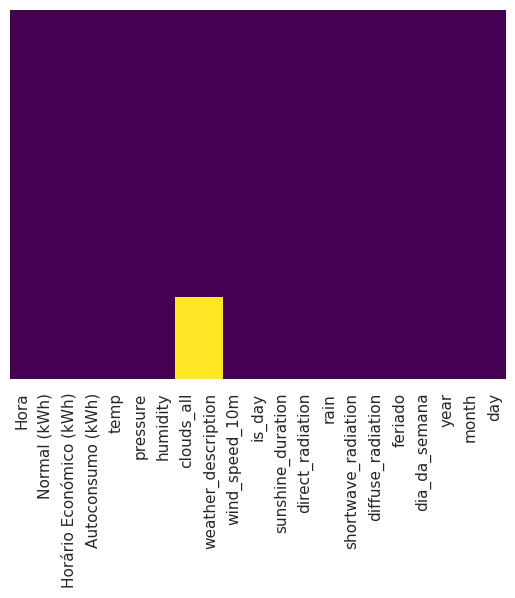

In [273]:
sns.heatmap(result.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [274]:
encoder_model = ce.BinaryEncoder(cols=['dia_da_semana'])
df_binary = encoder_model.fit_transform(result)
result = df_binary
result.head()

,Hora,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),temp,pressure,humidity,clouds_all,weather_description,wind_speed_10m,...,rain,shortwave_radiation,diffuse_radiation,feriado,dia_da_semana_0,dia_da_semana_1,dia_da_semana_2,year,month,day
0,0,0.0,0.467,0.0,12.93,1019.0,95.0,100.0,6.0,9.779817,...,3.7,0.0,0.0,True,0,0,1,2023,1,1
1,1,0.0,0.577,0.0,13.49,1018.0,95.0,100.0,6.0,11.874544,...,5.7,0.0,0.0,True,0,0,1,2023,1,1
2,2,0.0,0.346,0.0,13.55,1017.0,95.0,100.0,6.0,9.531505,...,8.7,0.0,0.0,True,0,0,1,2023,1,1
3,3,0.0,0.270,0.0,13.61,1016.0,95.0,100.0,6.0,12.074766,...,10.2,0.0,0.0,True,0,0,1,2023,1,1
4,4,0.0,0.252,0.0,13.59,1015.0,95.0,100.0,6.0,25.919998,...,2.6,0.0,0.0,True,0,0,1,2023,1,1


In [275]:
# res = grid_bg.predict(result)
# res = xgb_model.predict(result)
res = grid_xgb.predict(result)

replace_map={0:'None',1: 'Low',2: 'Medium', 3:'High', 4:'Very High'}

# Converter o array de resultados para um DataFrame para usar 'map'
df_resultados = pd.DataFrame(res, columns=['Result'])

# Usar 'map' para substituir os números pelas etiquetas originais
df_resultados['Result'] = df_resultados['Result'].map(replace_map)

# Imprimir número da linha e label
# for linha, row in df_resultados.iterrows():
#     print(f"{linha},{row['Result']}")

df_resultados['RowId'] = df_resultados.index + 1

# Reordenando as colunas para que RowId venha primeiro, se necessário
df = df_resultados[['RowId', 'Result']]

# Escrevendo o DataFrame para um arquivo CSV
df.to_csv('predictions.csv', index=False)